<a href="https://colab.research.google.com/github/DanielTeixeira23/simulacao_revisao_espacada/blob/main/Simula%C3%A7%C3%A3o_Revis%C3%A3o_Espa%C3%A7ada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


INICIANDO TESTE COM MSI DE 10

INICIANDO TESTE PARA HORIZONTE DE 15 DIAS


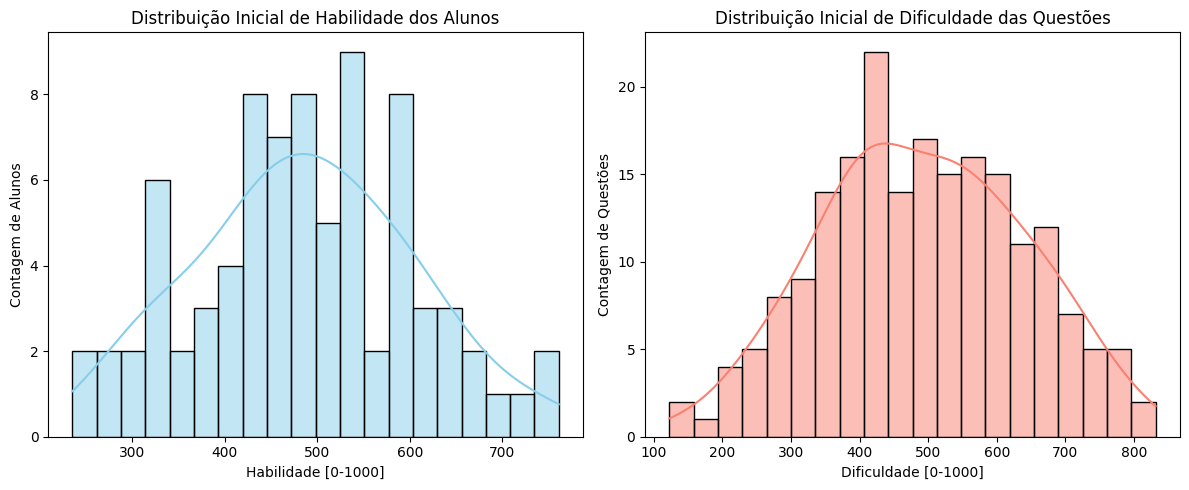


INICIANDO TESTE PARA HORIZONTE DE 30 DIAS


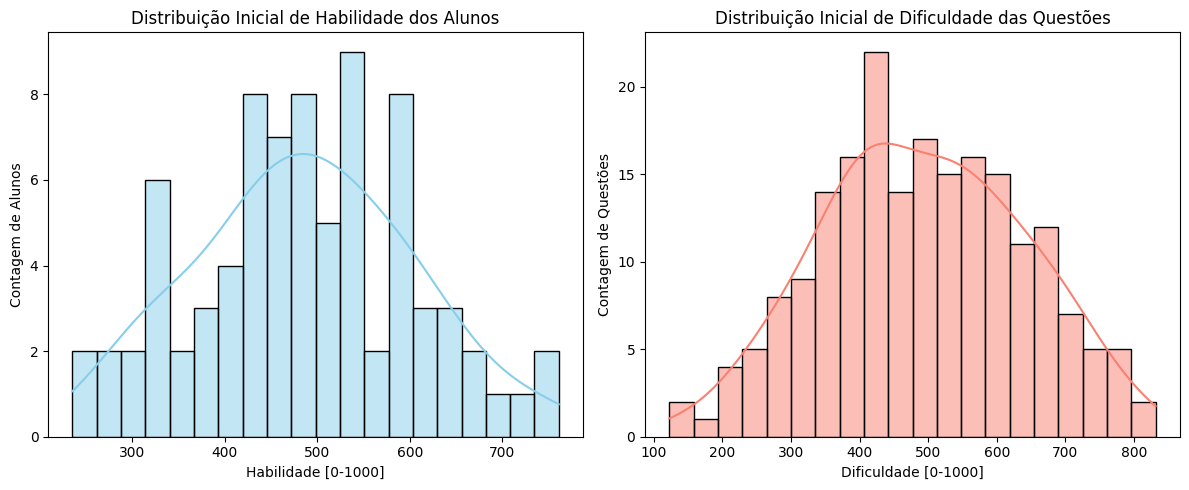


INICIANDO TESTE PARA HORIZONTE DE 60 DIAS


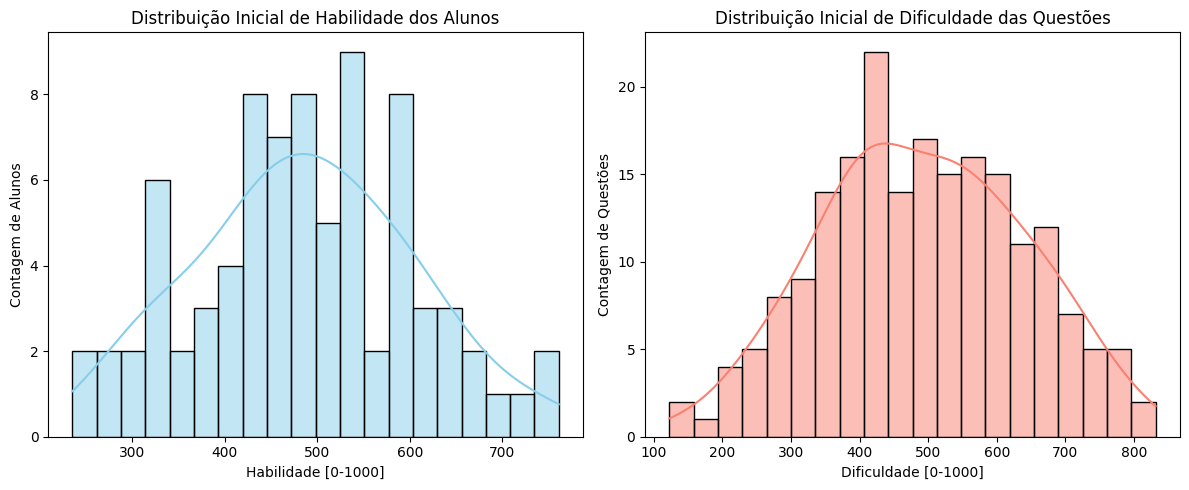


INICIANDO TESTE PARA HORIZONTE DE 120 DIAS


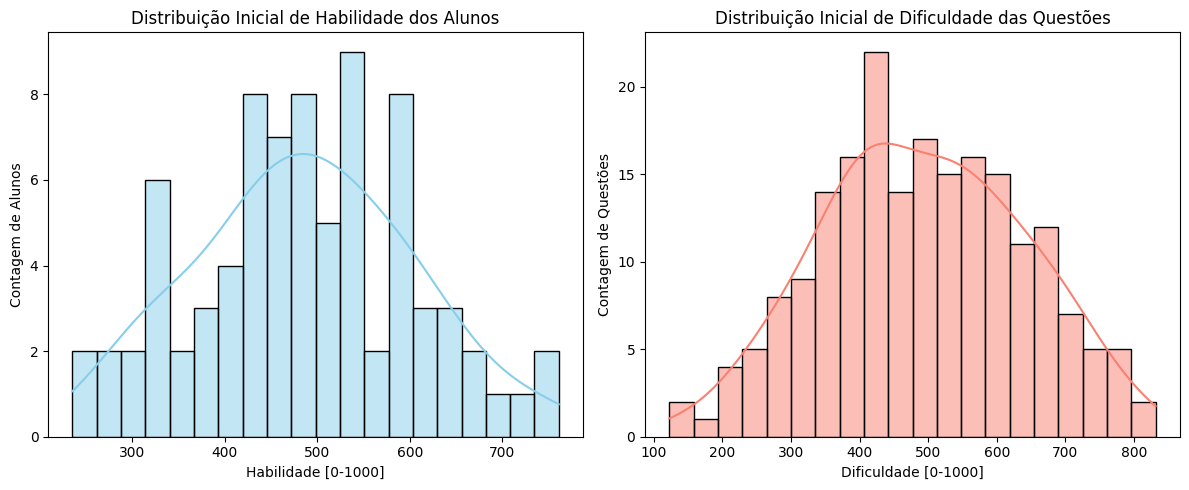


INICIANDO TESTE COM MSI DE 15

INICIANDO TESTE PARA HORIZONTE DE 15 DIAS


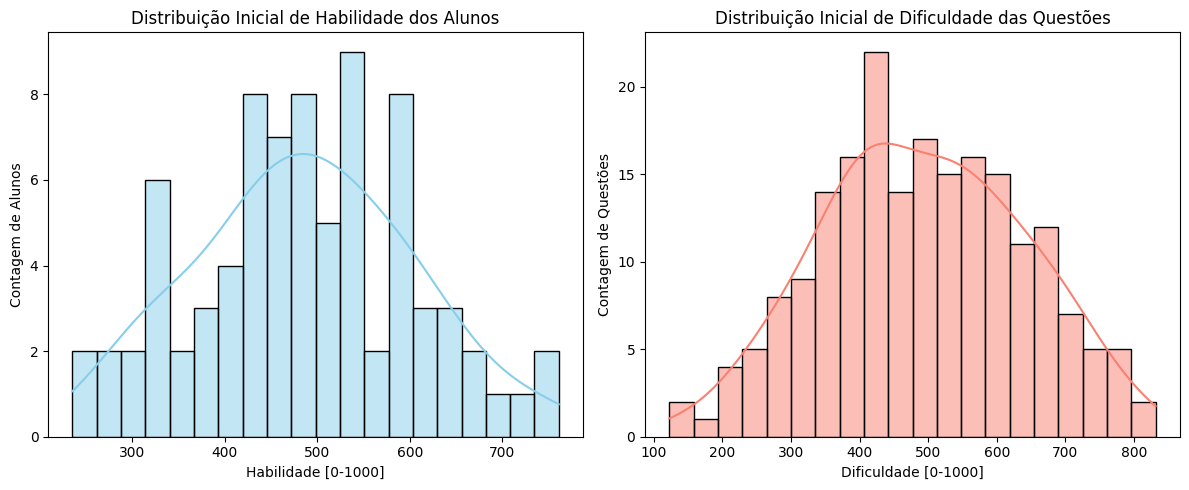


INICIANDO TESTE PARA HORIZONTE DE 30 DIAS


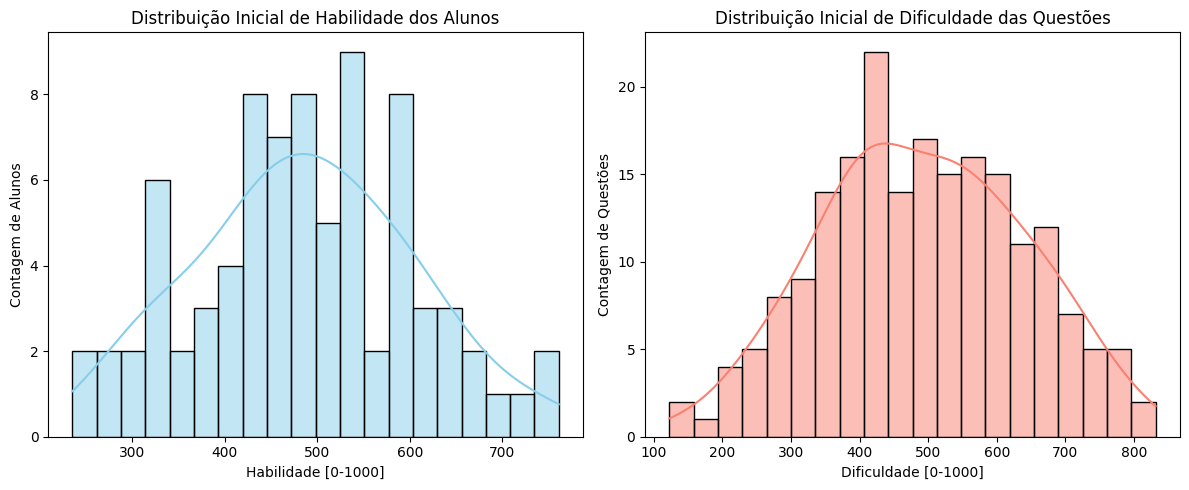


INICIANDO TESTE PARA HORIZONTE DE 60 DIAS


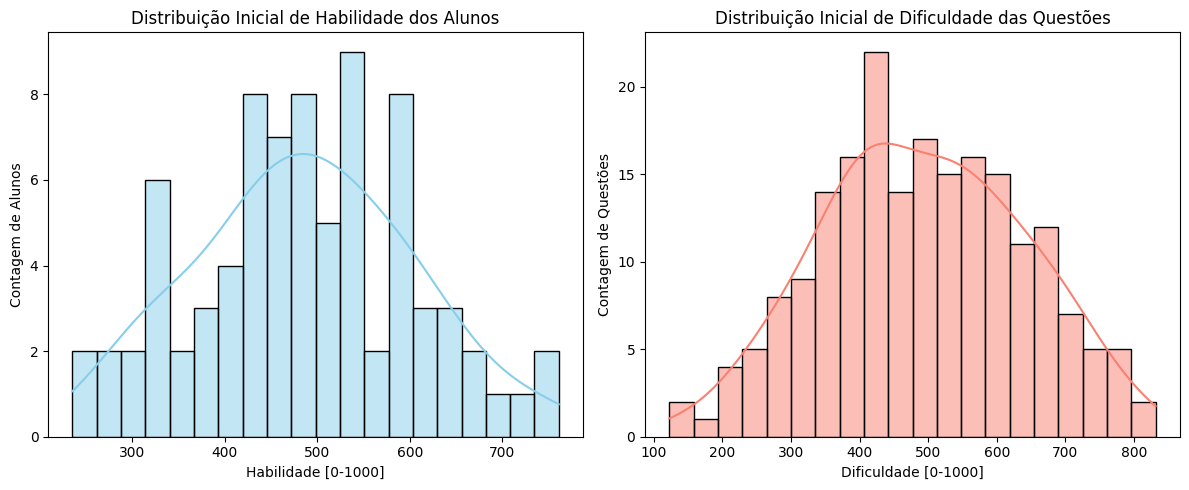


INICIANDO TESTE PARA HORIZONTE DE 120 DIAS


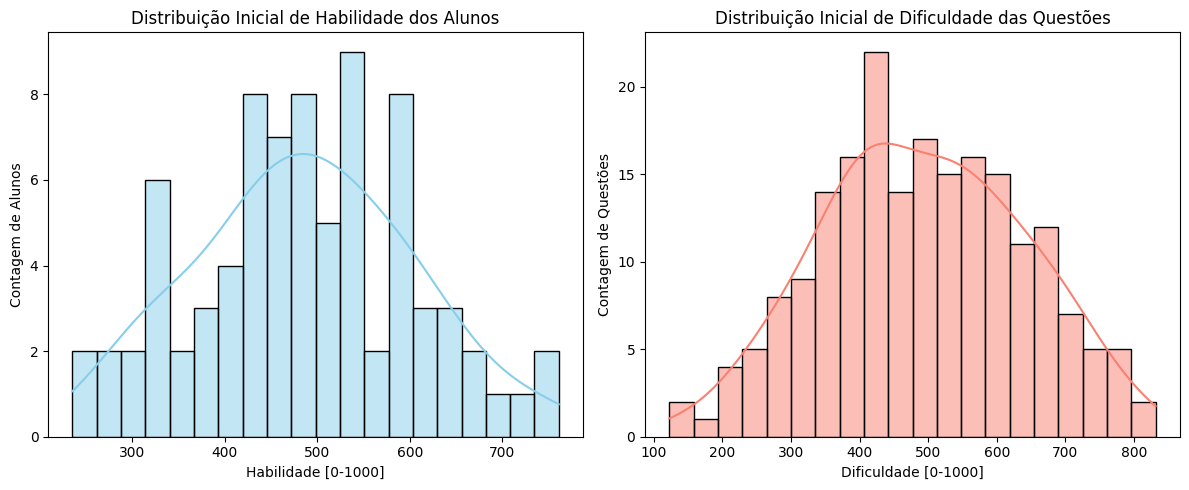


INICIANDO TESTE COM MSI DE 20

INICIANDO TESTE PARA HORIZONTE DE 15 DIAS


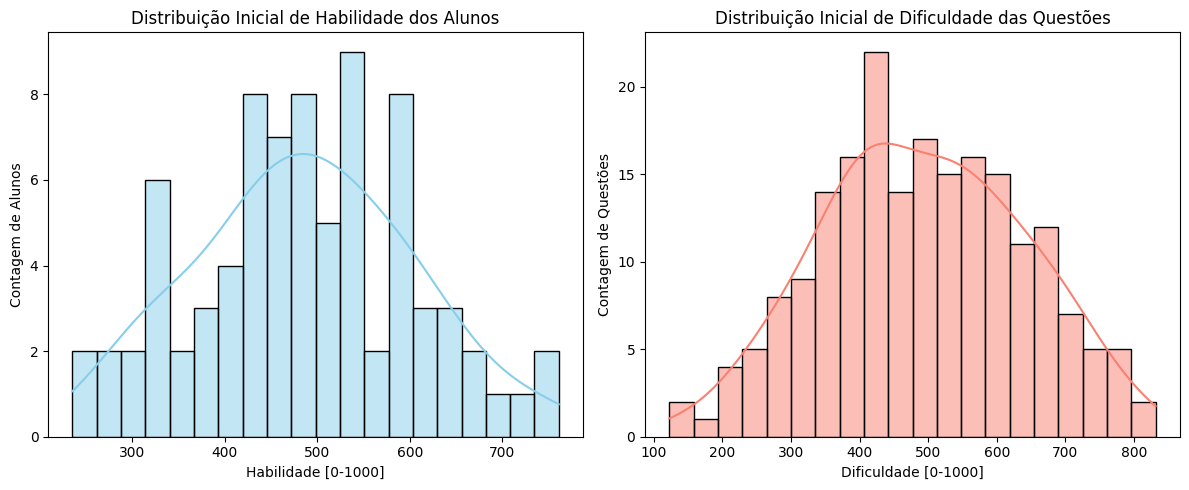


INICIANDO TESTE PARA HORIZONTE DE 30 DIAS


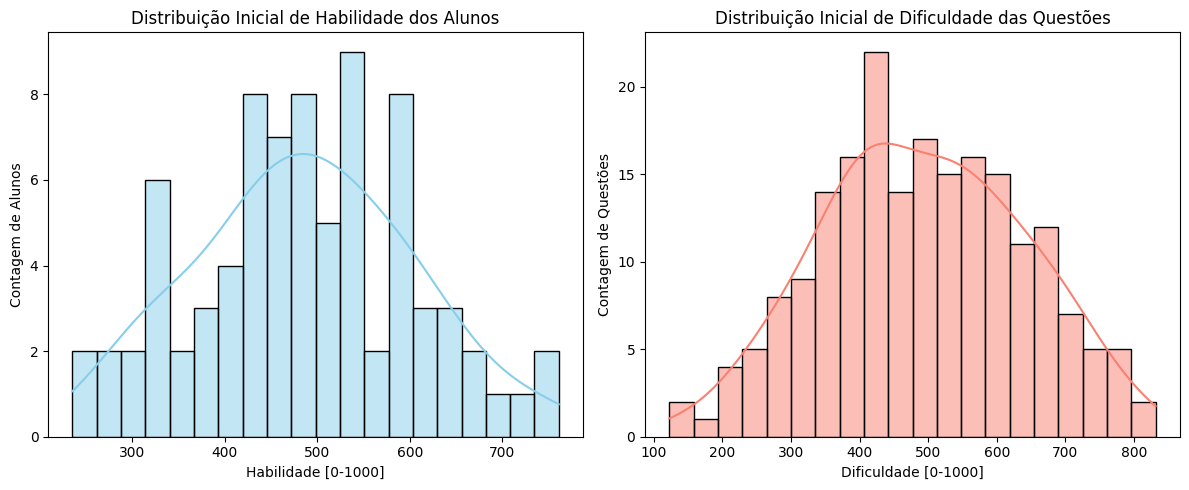


INICIANDO TESTE PARA HORIZONTE DE 60 DIAS


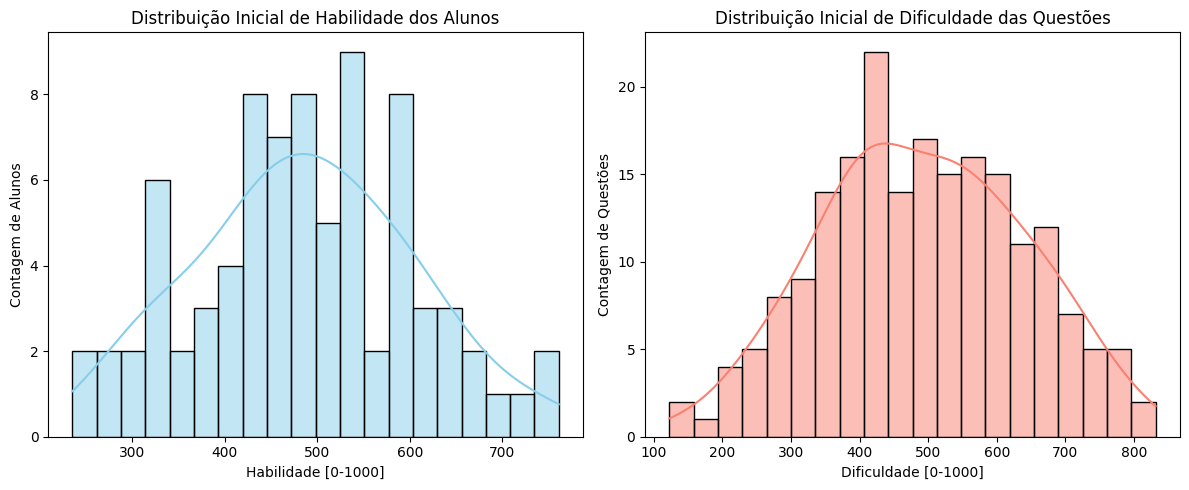


INICIANDO TESTE PARA HORIZONTE DE 120 DIAS


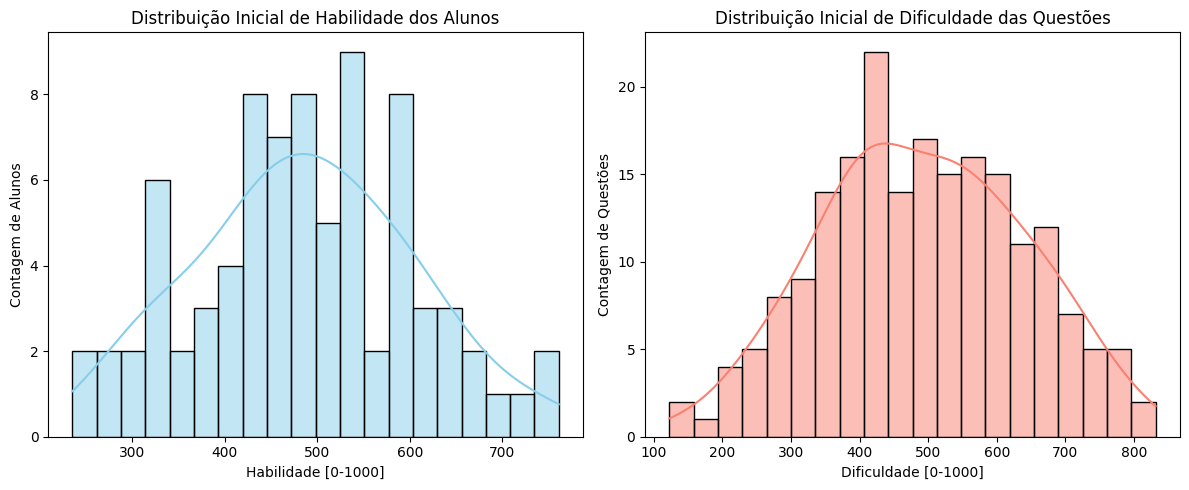


INICIANDO TESTE COM MSI DE 25

INICIANDO TESTE PARA HORIZONTE DE 15 DIAS


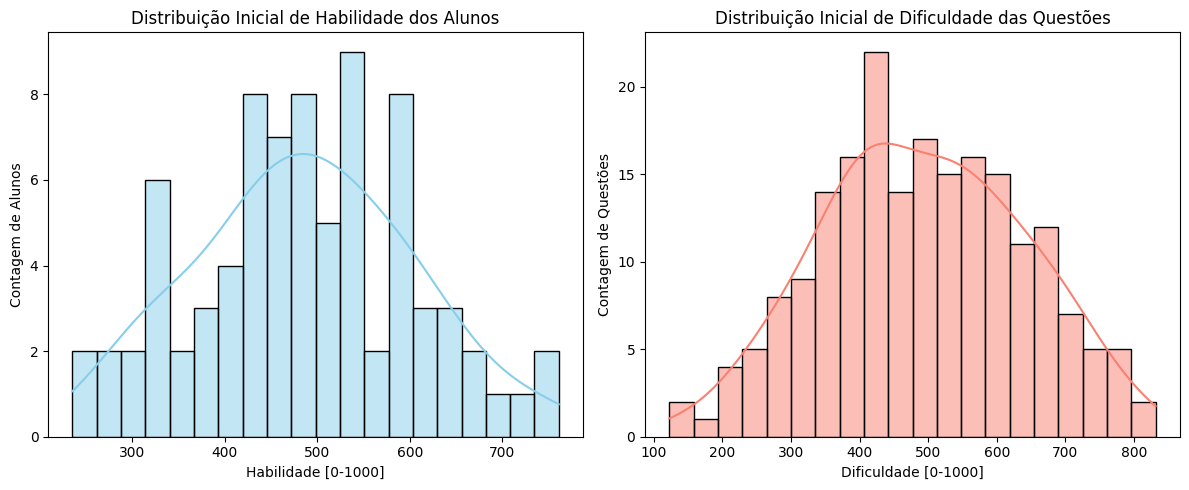


INICIANDO TESTE PARA HORIZONTE DE 30 DIAS


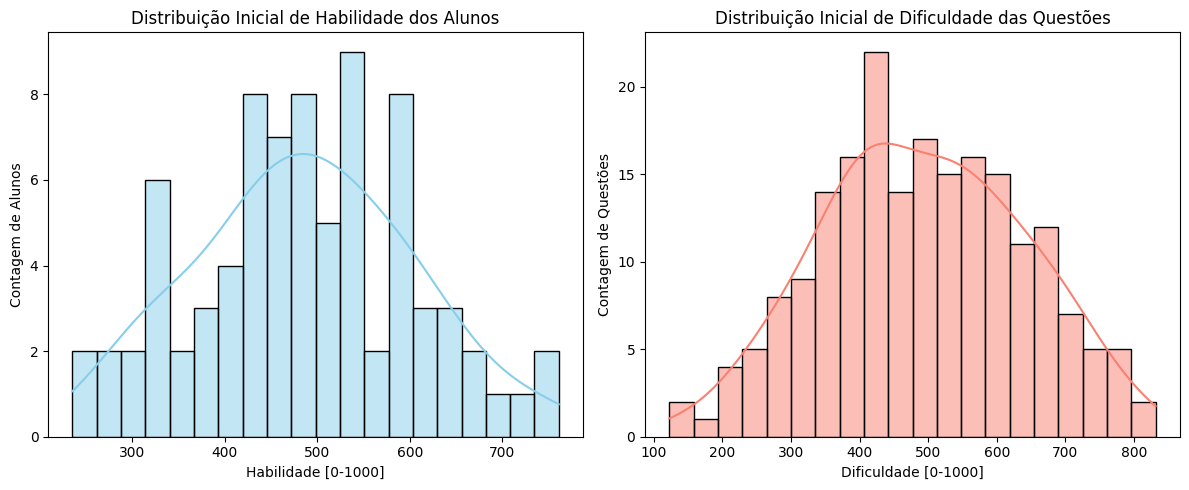


INICIANDO TESTE PARA HORIZONTE DE 60 DIAS


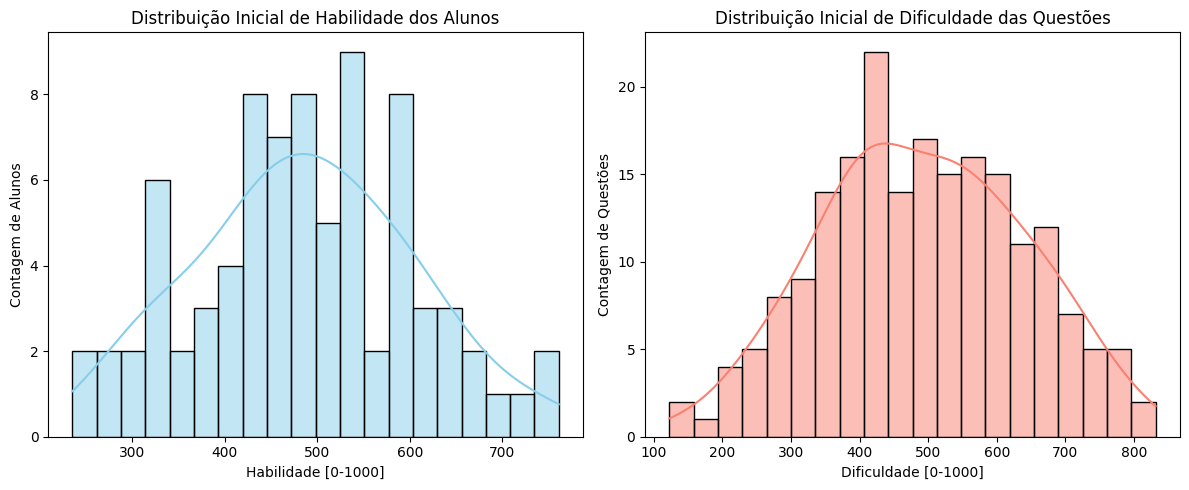


INICIANDO TESTE PARA HORIZONTE DE 120 DIAS


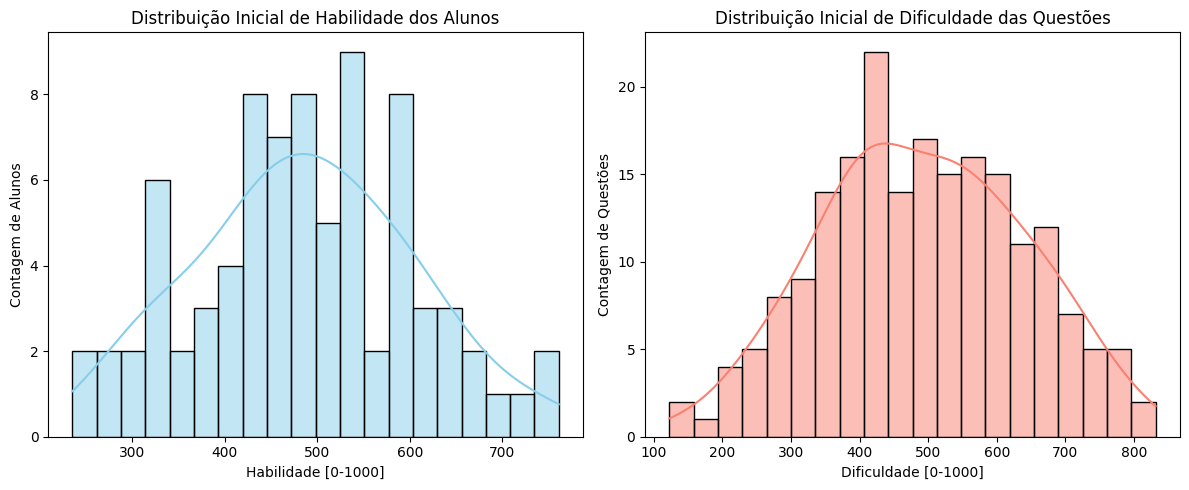


--- SIMULAÇÃO GERAL CONCLUÍDA ---
Total de 4 horizontes testados.
Total de 4 valores de MSI testados: [10, 15, 20, 25]
Dados de Simulação (Total de Respostas): 556227
Dados de Pós-Teste (Total de Respostas): 768000

--- Métrica A: Frequência de Fallback (Indica Saturação) ---


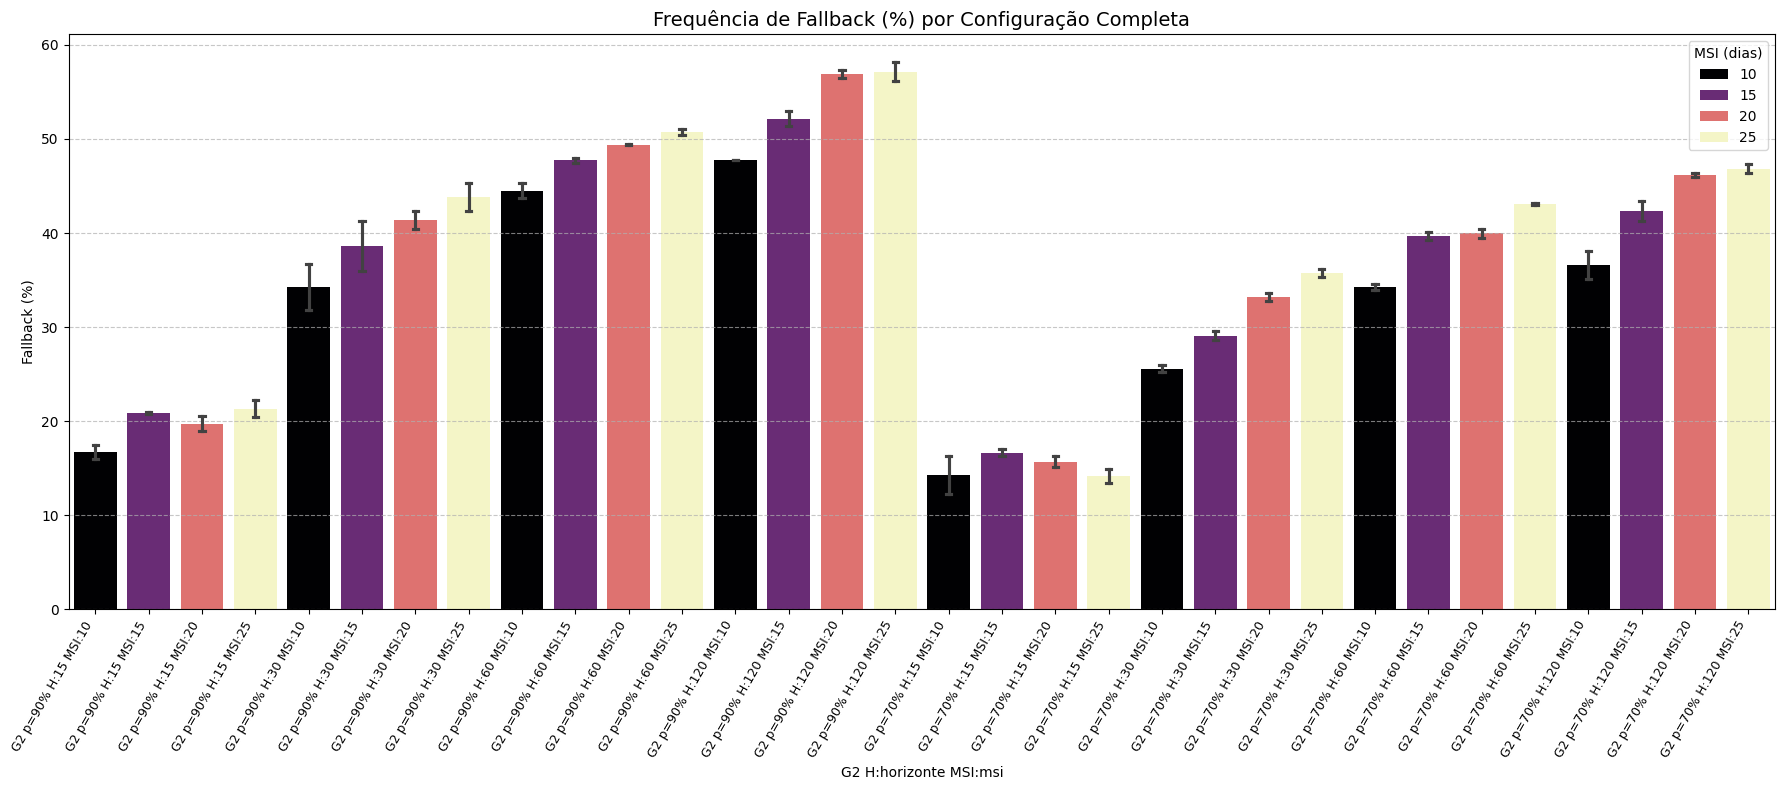

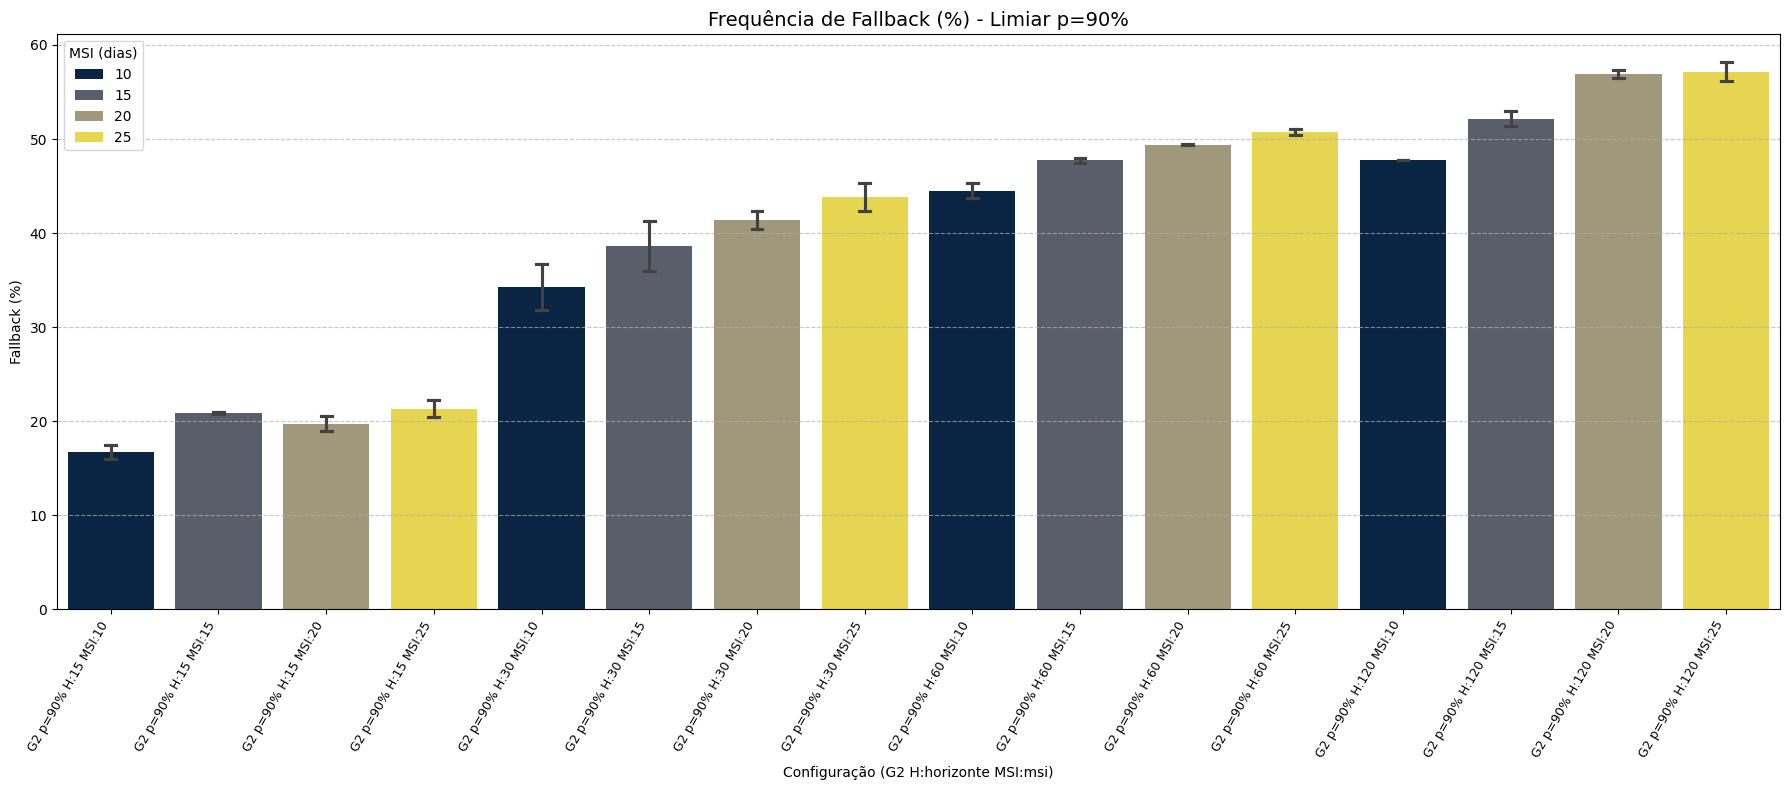

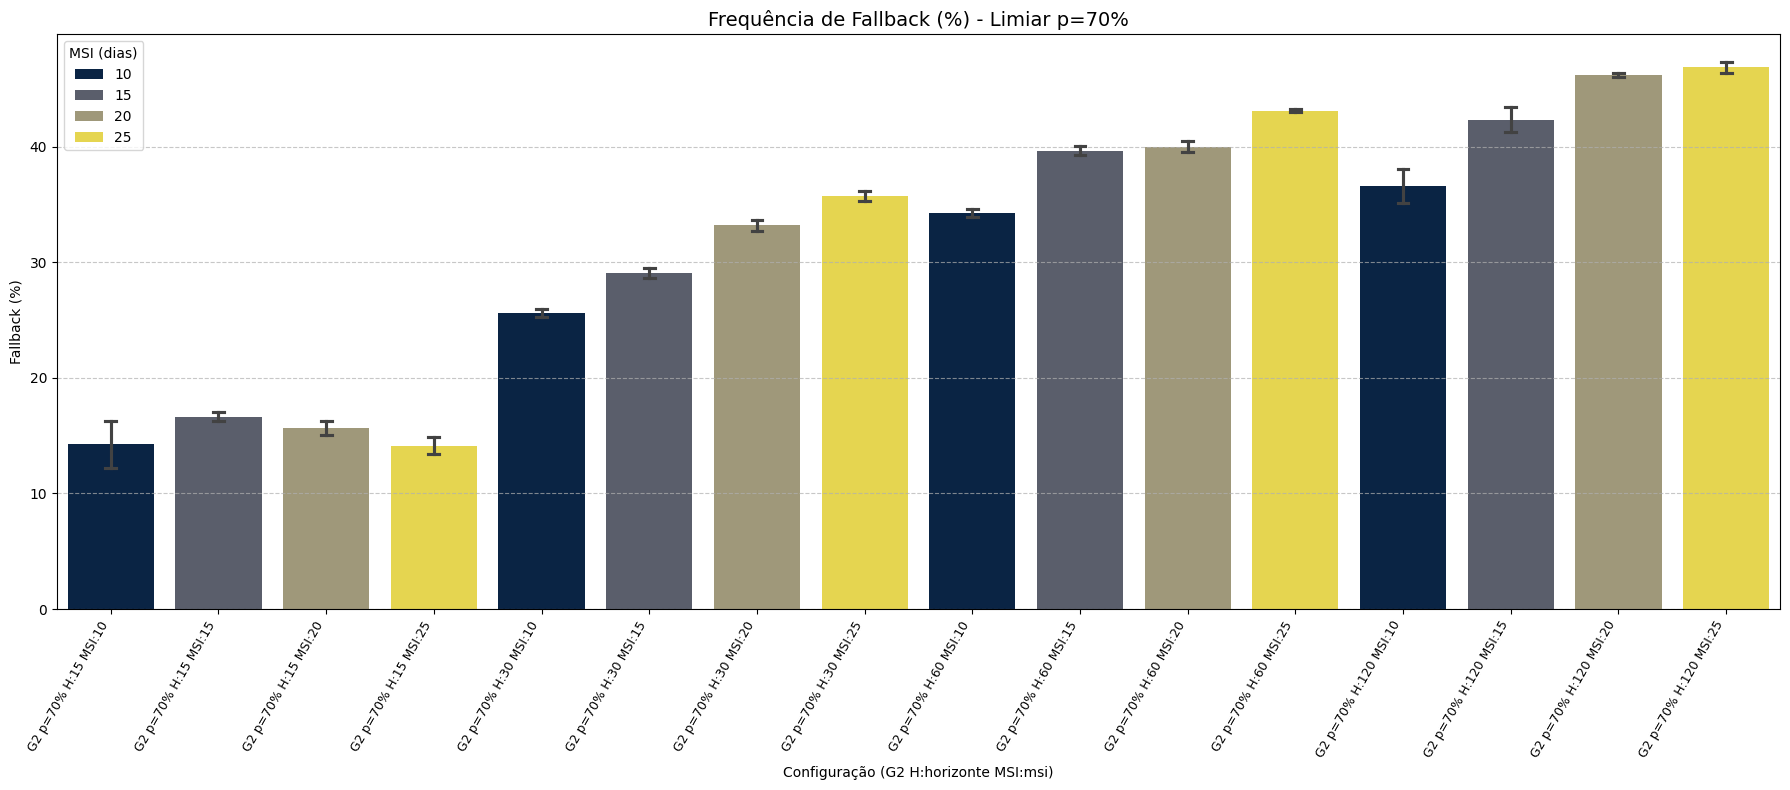

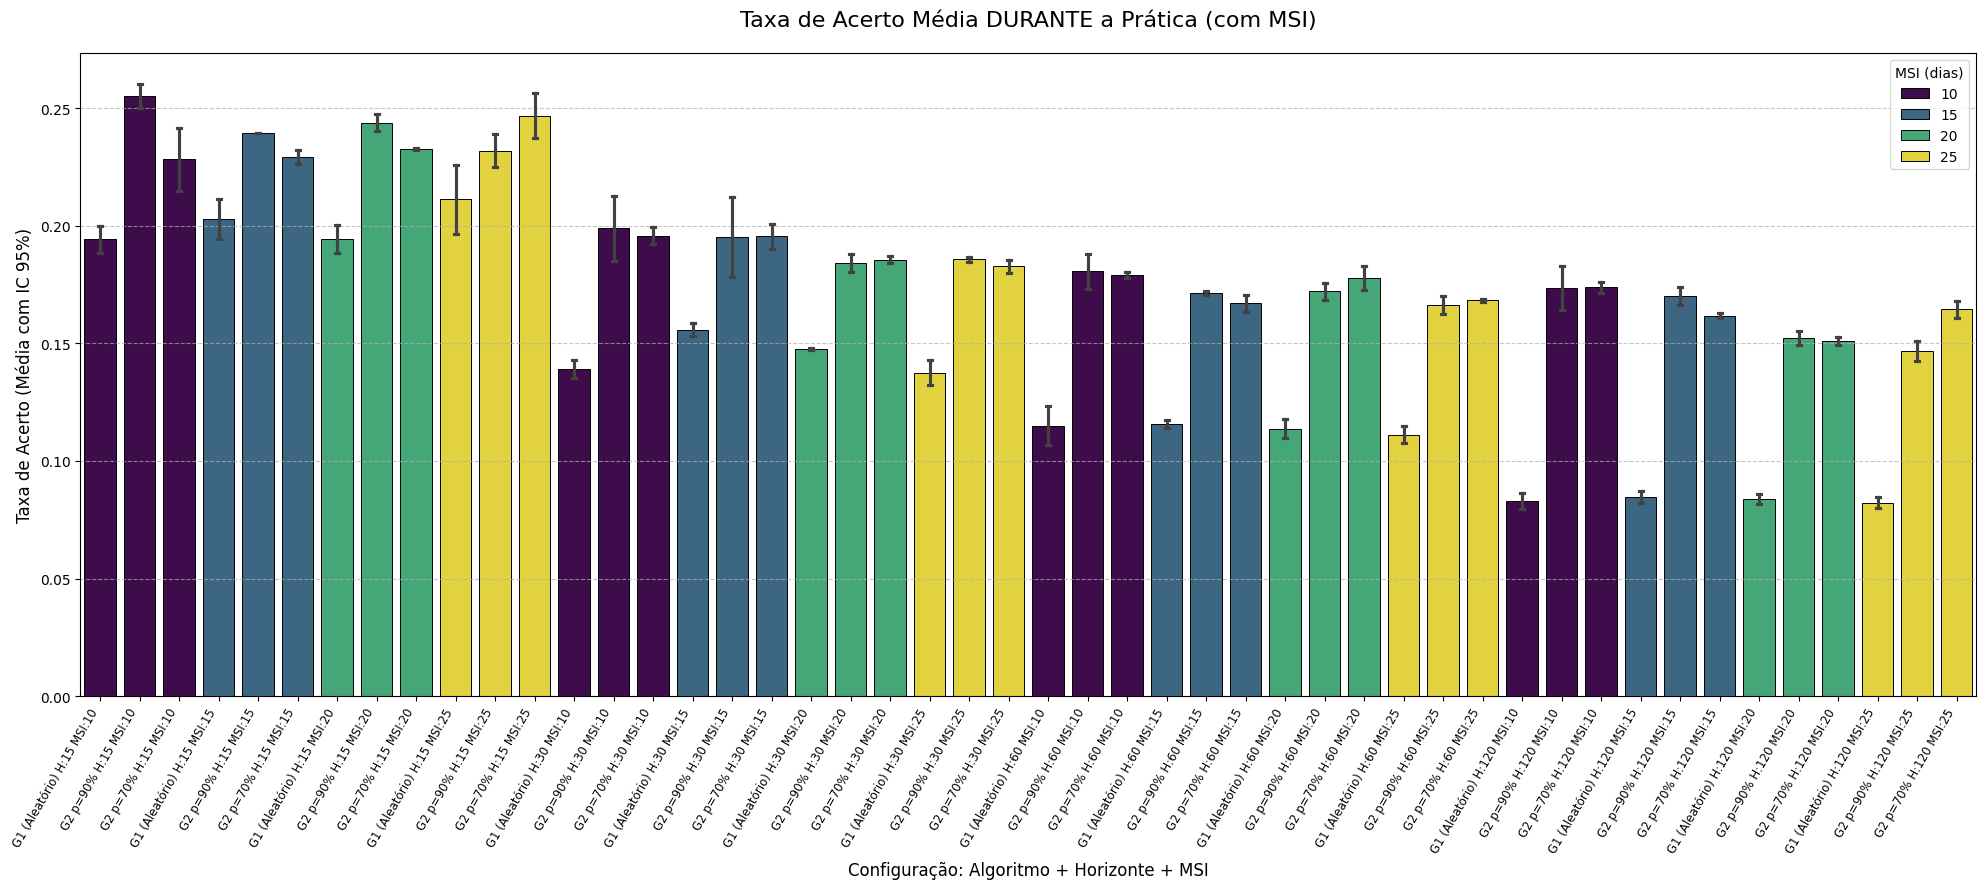

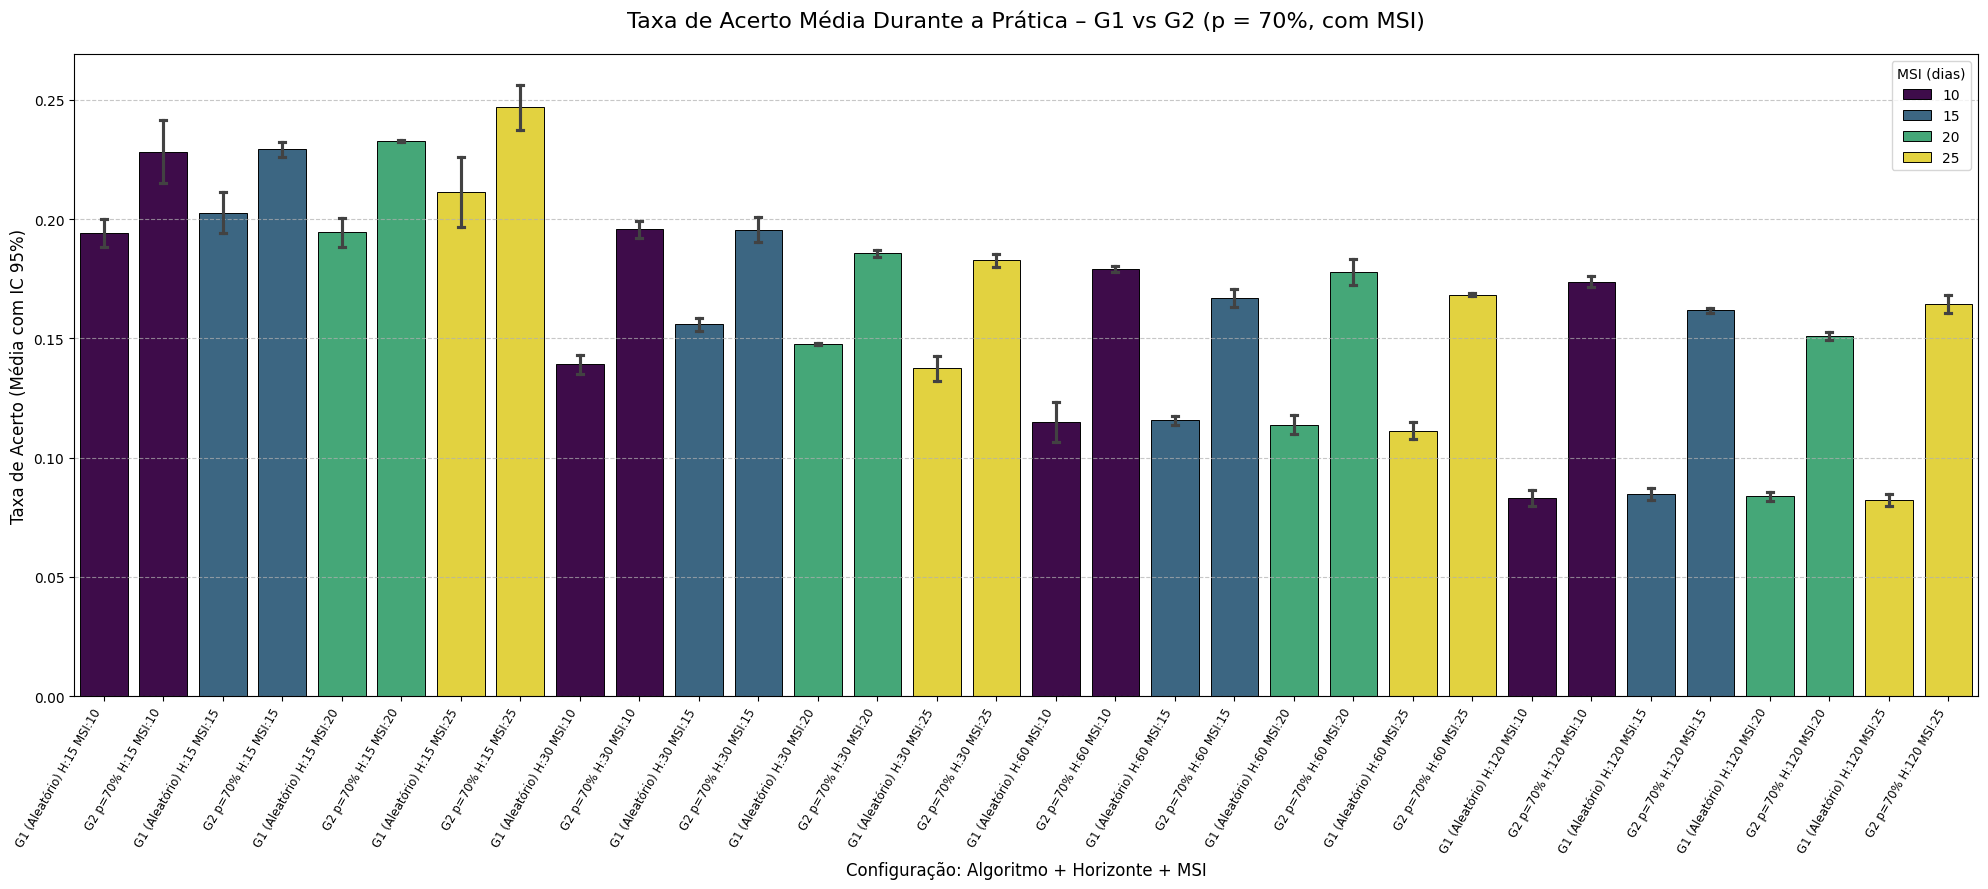

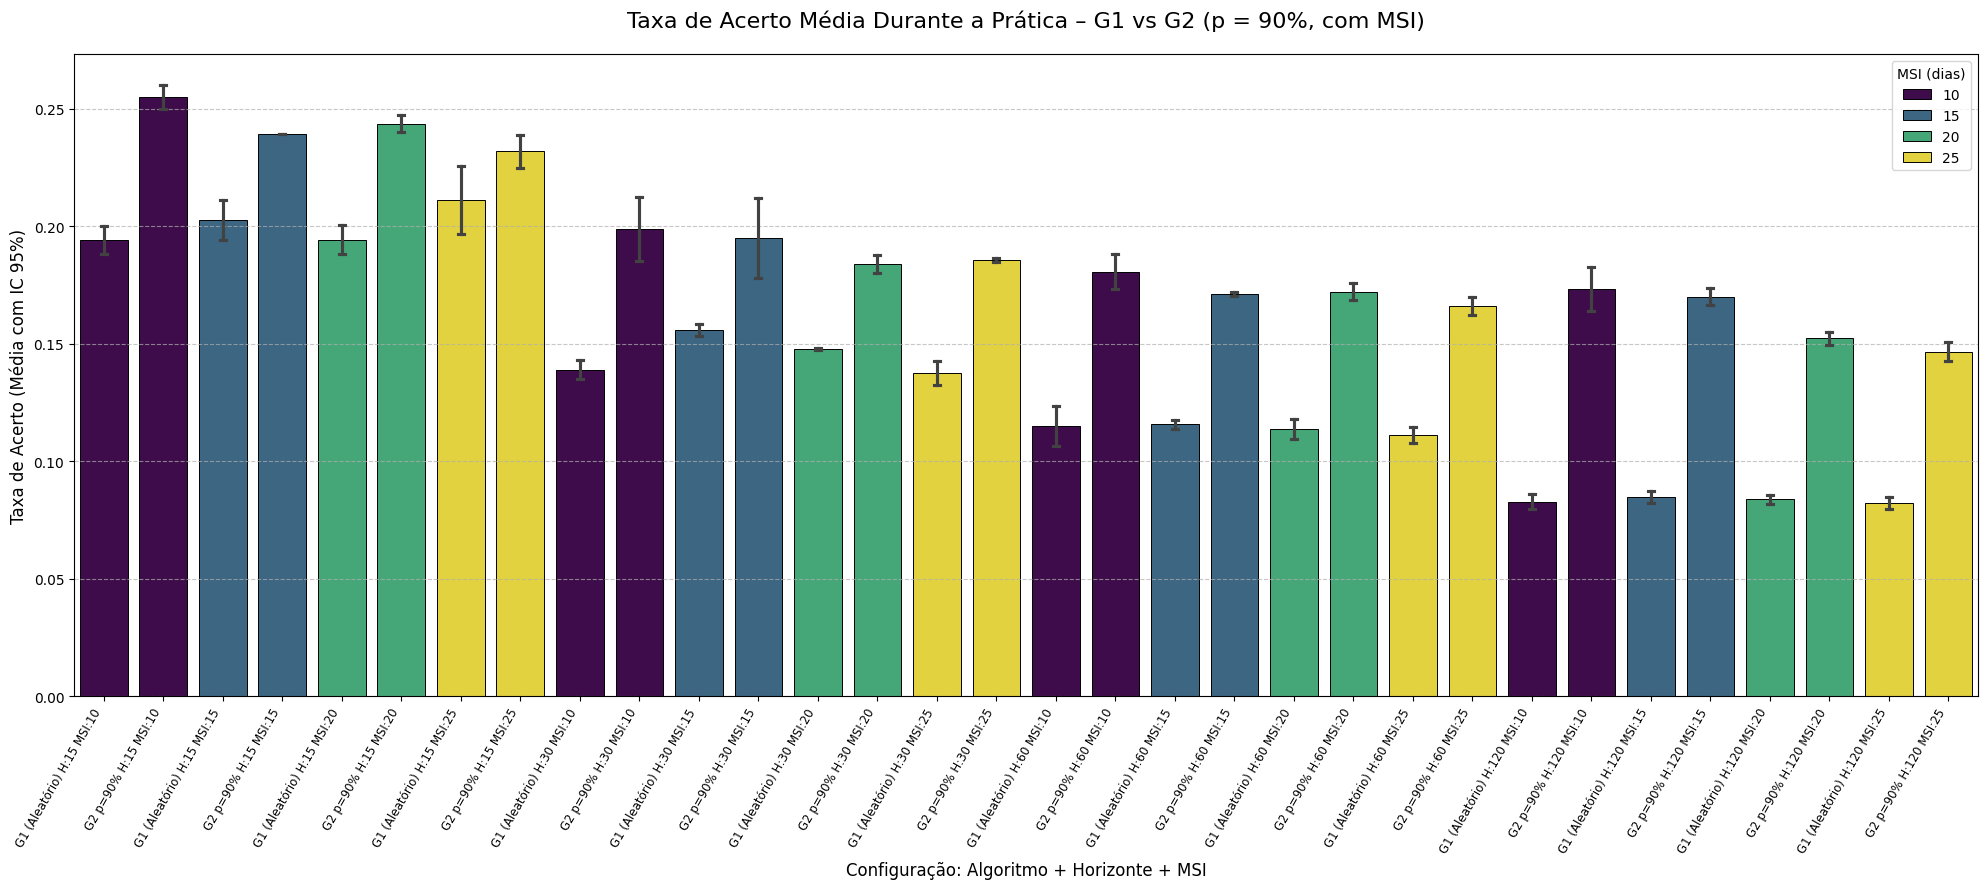

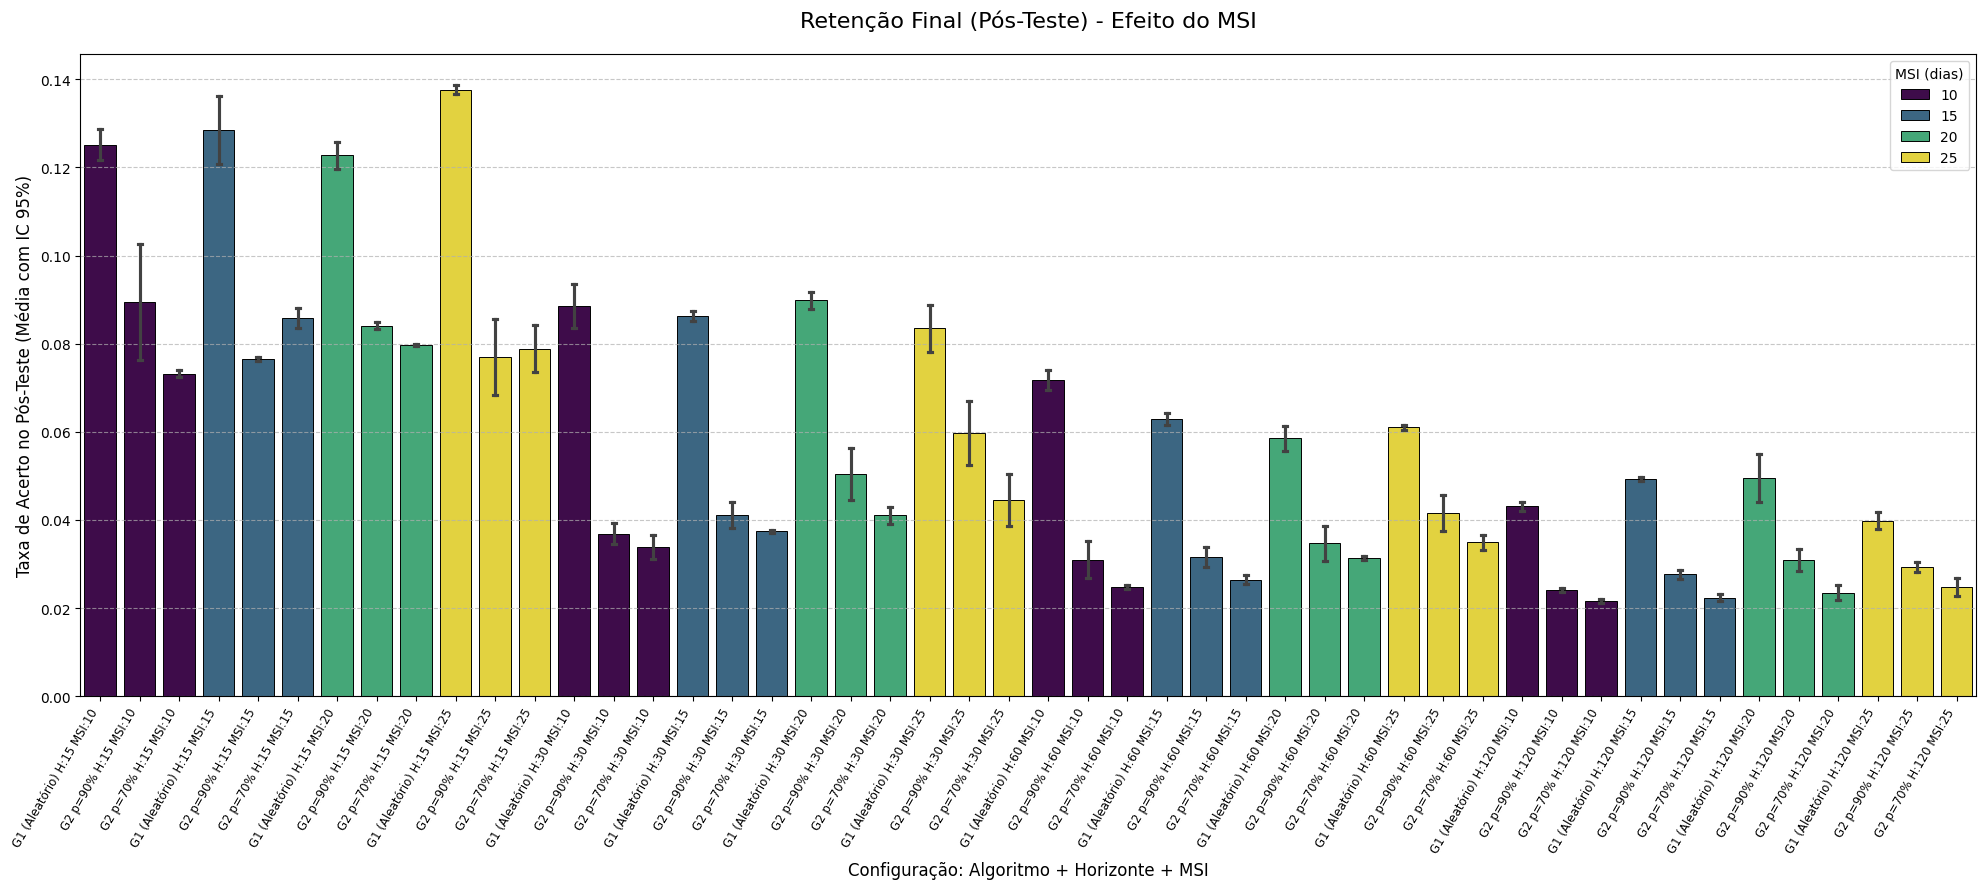


--- Métrica 7: Carga de Revisão por Subtema (com MSI) ---


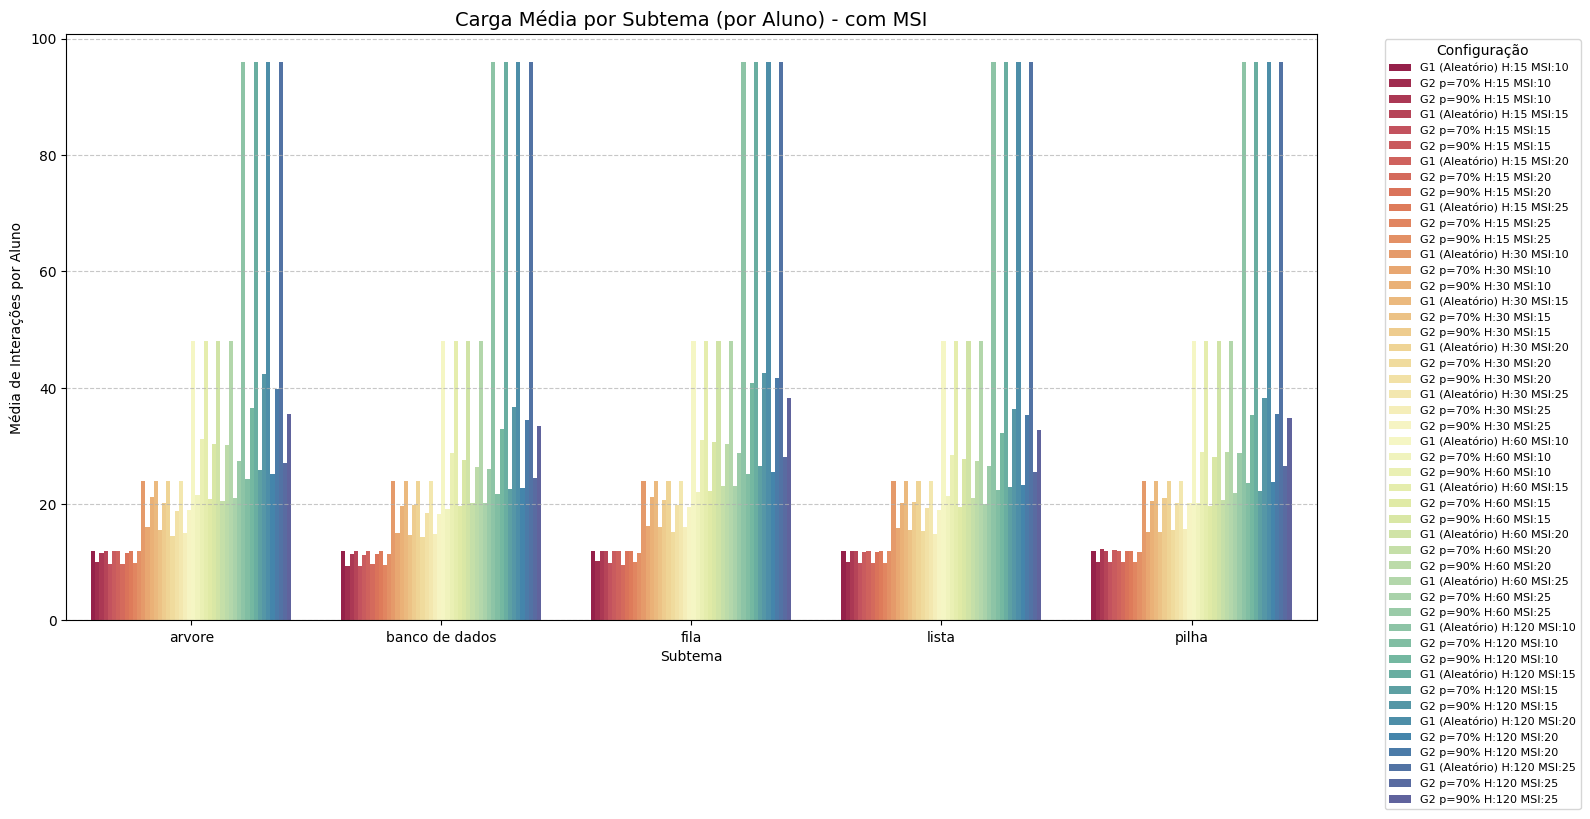


[TABELA DE CARGA POR SUBTEMA]
q_subtema                    arvore  banco de dados   fila  lista  pilha
config_completa                                                         
G1 (Aleatório) H:120 MSI:10   96.00           96.00  96.00  96.00  96.00
G1 (Aleatório) H:120 MSI:15   96.00           96.00  96.00  96.00  96.00
G1 (Aleatório) H:120 MSI:20   96.00           96.00  96.00  96.00  96.00
G1 (Aleatório) H:120 MSI:25   96.00           96.00  96.00  96.00  96.00
G1 (Aleatório) H:15 MSI:10    12.00           12.00  12.00  12.00  12.00
G1 (Aleatório) H:15 MSI:15    12.00           12.00  12.00  12.00  12.00
G1 (Aleatório) H:15 MSI:20    12.00           12.00  12.00  12.00  12.00
G1 (Aleatório) H:15 MSI:25    12.00           12.00  12.00  12.00  12.00
G1 (Aleatório) H:30 MSI:10    24.00           24.00  24.00  24.00  24.00
G1 (Aleatório) H:30 MSI:15    24.00           24.00  24.00  24.00  24.00
G1 (Aleatório) H:30 MSI:20    24.00           24.00  24.00  24.00  24.00
G1 (Aleatório) H:30 

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import truncnorm
from tqdm import tqdm
from scipy import stats
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings
warnings.filterwarnings('ignore')


FALLBACK_NONE = 'none'
FALLBACK_LEVEL1 = 'level1_urgency'
FALLBACK_LEVEL2 = 'level2_item_selection'
FB_REASON_OK = 'ok'
FB_REASON_NO_URGENT_SUBTOPIC = 'no_subtopic_below_threshold'
FB_REASON_NO_ITEMS_IN_RANGE = 'no_items_in_difficulty_range'
FB_REASON_MSI_BLOCKED = 'msi_blocked_all_candidates'
FB_REASON_USED_ALL_SUBTEMA = 'range_empty_used_all_subtema'


N_ROUNDS = 2
FIXED_SEED_INIT = 42
THRESHOLDS_P = [0.9, 0.7]
TIME_HORIZONS = [15, 30, 60, 120]
MIN_SPACING_INTERVALS = [10, 15, 20, 25]

N_STUDENTS = 80
N_GROUP = 40
N_QUESTIONS = 200
N_SUBTEMAS = 5
N_QUESTIONS_PER_SUBTEMA = N_QUESTIONS // N_SUBTEMAS

PRATICAL_LOAD = 4
H_MIN = 1.0
H_MAX = 365.0
K_ABILITY_UPDATE = 32
P_TARGET_ITEM_SELECTION = 0.50
DIFFICULTY_RANGE_MARGIN = 150

def get_truncated_normal(mean=0, sd=1, low=0, high=1000):
    return truncnorm((low - mean) / sd, (high - mean) / sd, loc=mean, scale=sd).rvs

def fibonacci(n):
    if n <= 1:
        return 1
    a, b = 1, 1
    for _ in range(2, n + 1):
        a, b = b, a + b
        if a > 1000000:
            return b
    return b

def simple_logistic_prob(ability, difficulty):
    p = 1 / (1 + np.exp(-(ability - difficulty) / 100))
    return np.clip(p, 0.01, 0.99)

rng = np.random.default_rng()

def get_dynamic_kappa(total_interactions, kappa_max=50, kappa_min=10, growth_rate=0.5):
    kappa = kappa_min + total_interactions * growth_rate
    return np.clip(kappa, kappa_min, kappa_max)

def sample_with_overdispersion(p, kappa=50):
    alpha = max(p * kappa, 1e-6)
    beta  = max((1 - p) * kappa, 1e-6)
    p_pert = rng.beta(alpha, beta)
    return 1 if rng.random() < p_pert else 0

def generalized_probability(ability, difficulty, dt, h):
    base_prob = simple_logistic_prob(ability, difficulty)
    retention_rate = 0.5 ** (dt / h)
    p_acerto = base_prob * retention_rate

    return np.clip(p_acerto, 0.01, 0.99)

def update_ability(student, q, result):
    K = K_ABILITY_UPDATE
    p_acerto_update = simple_logistic_prob(student.ability, q.difficulty)
    correction = K * (result - p_acerto_update)
    new_ability = student.ability + correction
    student.ability = np.clip(new_ability, 0.0, 1000.0)
    return correction, p_acerto_update

class Question:
    def __init__(self, q_id, subtema, difficulty):
        self.q_id = q_id
        self.subtema = subtema
        self.difficulty = difficulty
        self.h = H_MIN
        self.last_day_seen = 0

    def __repr__(self):
        return f"Q{self.q_id} ({self.subtema}, D:{self.difficulty:.0f}, h:{self.h:.1f})"

class Student:
    def __init__(self, s_id, group, ability):
        self.s_id = s_id
        self.group = group
        self.ability = ability
        self.history = []
        self.correct_count = 0
        self.error_count = 0
        self.questions_state = {}
        self.random_sequence_index = 0

        SUBTEMAS = ['pilha', 'fila', 'lista', 'arvore', 'banco de dados']
        self.subtema_h = {t: H_MIN for t in SUBTEMAS}
        self.subtema_last_seen = {t: 0 for t in SUBTEMAS}
        self.subtema_total_interactions = {t: 0 for t in SUBTEMAS}
        self.subtema_correct_streak = {t: 0 for t in SUBTEMAS}
        self.subtema_error_streak = {t: 0 for t in SUBTEMAS}

    def __repr__(self):
        return f"S{self.s_id} (G:{self.group}, A:{self.ability:.0f})"


def update_half_life(q, student, result):
    subtema = q.subtema
    diff_ratio = student.ability / (q.difficulty + 1e-6)
    h_current = student.subtema_h[subtema]
    h_correct_streak = student.subtema_correct_streak[subtema]
    h_error_streak = student.subtema_error_streak[subtema]

    if result == 1:
        h_correct_streak += 1
        h_error_streak = 0

        f_inc = fibonacci(h_correct_streak)
        increment = diff_ratio * f_inc
        h_new = h_current + increment

    else:
        h_error_streak += 1
        h_correct_streak = 0
        increment = ((q.difficulty + 1e-6) / (student.ability + 1e-6)) * fibonacci(h_error_streak)
        h_new = H_MIN + (increment / 10)

    student.subtema_correct_streak[subtema] = h_correct_streak
    student.subtema_error_streak[subtema] = h_error_streak

    student.subtema_h[subtema] = np.clip(h_new, H_MIN, H_MAX)


def msi_ok(q, current_day, min_spacing):
    return (q.last_day_seen == 0) or ((current_day - q.last_day_seen) >= min_spacing)

def select_best_item_for_macro_topic(student, subtema_escolhido, current_day, min_spacing):
    target_p = P_TARGET_ITEM_SELECTION
    best_q = None
    min_diff = float('inf')
    h_ability = student.ability
    margin = DIFFICULTY_RANGE_MARGIN

    # 1. FAIXA DE DIFICULDADE
    lower_bound = np.clip(h_ability - margin, 0, 1000)
    upper_bound = np.clip(h_ability + margin, 0, 1000)

    # 2. FILTRO POR SUBTEMA E DIFICULDADE
    questions_in_topic = [
        q for q_id, q in student.questions_state.items()
        if (q.subtema == subtema_escolhido and
            q.difficulty >= lower_bound and
            q.difficulty <= upper_bound)
    ]

    range_empty = (len(questions_in_topic) == 0)

    # 3. APLICA O MSI (somente G2)
    if student.group != 'G1':
        questions_in_topic = [q for q in questions_in_topic if msi_ok(q, current_day, min_spacing)]

    # 4. FALLBACK: nenhuma questão disponível no range/MSI
    level2_reason = FB_REASON_OK
    if not questions_in_topic:
        questions_in_topic_all = [
            q for q_id, q in student.questions_state.items()
            if q.subtema == subtema_escolhido
        ]

        used_all_subtema = False
        if student.group != 'G1':
            questions_in_topic = [q for q in questions_in_topic_all if msi_ok(q, current_day, min_spacing)]
            used_all_subtema = True
        else:
            questions_in_topic = questions_in_topic_all

        if not questions_in_topic:
            if range_empty:
                reason = FB_REASON_NO_ITEMS_IN_RANGE
            else:
                reason = FB_REASON_MSI_BLOCKED
            return None, 0, True, FALLBACK_LEVEL2, reason

        # Se conseguiu item só porque ampliou o escopo
        if used_all_subtema:
            level2_reason = FB_REASON_USED_ALL_SUBTEMA

    # 5. Seleciona a questão mais próxima de P=0.5
    for q in questions_in_topic:
        p_base = simple_logistic_prob(student.ability, q.difficulty)
        diff = abs(p_base - target_p)
        if diff < min_diff:
            min_diff = diff
            best_q = q

    if best_q is None and questions_in_topic:
        best_q = questions_in_topic[0]

    dt = current_day - student.subtema_last_seen.get(subtema_escolhido, 0)
    h_subtema = student.subtema_h.get(subtema_escolhido, H_MIN)
    p_est_revisao = generalized_probability(student.ability, best_q.difficulty, dt, h_subtema)

    is_fallback = (level2_reason != FB_REASON_OK)
    return best_q, p_est_revisao, is_fallback, (FALLBACK_LEVEL2 if is_fallback else FALLBACK_NONE), level2_reason


# FUNÇÃO PRINCIPAL DE SELEÇÃO (HLR)
def select_question_hlr(student, questions_pool, current_day, threshold_p, min_spacing):
    if not student.questions_state:
        for q_id, q_data in questions_pool.items():
            student.questions_state[q_id] = Question(q_id=q_data.q_id, subtema=q_data.subtema, difficulty=q_data.difficulty)

    subtema_urgency = {}
    for subtema in student.subtema_h.keys():
        dt = current_day - student.subtema_last_seen[subtema]
        h_subtema = student.subtema_h[subtema]
        p_retention = 0.5 ** (dt / h_subtema)
        if p_retention < threshold_p:
            subtema_urgency[subtema] = p_retention

    # NÍVEL 1: DECISÃO MACRO (QUAL SUBTEMA REVISAR)
    if subtema_urgency:
        subtema_escolhido = min(subtema_urgency, key=subtema_urgency.get)
        lvl1_fallback = False
        lvl1_reason = FB_REASON_OK
    else:
        # Sem urgentes: NÃO seleciona subtema; sinaliza fallback de L1 e encerra
        return None, 0.0, True, FALLBACK_LEVEL1, FB_REASON_NO_URGENT_SUBTOPIC

    # NÍVEL 2: DECISÃO MICRO (QUAL QUESTÃO ESCOLHER)
    selected_q, p_est_revisao, lvl2_fallback, lvl2_stage, lvl2_reason = select_best_item_for_macro_topic(
        student, subtema_escolhido, current_day, min_spacing
    )

    is_fallback = lvl1_fallback or lvl2_fallback
    if lvl2_fallback:
        fb_stage, fb_reason = lvl2_stage, lvl2_reason
    elif lvl1_fallback:
        fb_stage, fb_reason = FALLBACK_LEVEL1, lvl1_reason
    else:
        fb_stage, fb_reason = FALLBACK_NONE, FB_REASON_OK

    return selected_q, p_est_revisao, is_fallback, fb_stage, fb_reason


# 3. Inicialização e Simulação
def initialize_experiment(seed, horizonte_temporal):
    np.random.seed(seed)
    subthemes = (['pilha'] * N_QUESTIONS_PER_SUBTEMA + ['fila'] * N_QUESTIONS_PER_SUBTEMA + ['lista'] * N_QUESTIONS_PER_SUBTEMA +
                 ['arvore'] * N_QUESTIONS_PER_SUBTEMA + ['banco de dados'] * N_QUESTIONS_PER_SUBTEMA)
    difficulties = get_truncated_normal(mean=500, sd=150, low=0, high=1000)(N_QUESTIONS)
    paired_data = list(zip(subthemes, difficulties))
    np.random.shuffle(paired_data)

    questions_pool = {}
    for i in range(N_QUESTIONS):
        q_id = i + 1
        subtema, difficulty = paired_data[i]
        questions_pool[q_id] = Question(q_id, subtema, difficulty)

    q_ids = list(range(1, N_QUESTIONS + 1))
    np.random.shuffle(q_ids)

    # Usamos uma estimativa, mas o G1 precisa da sequência para o número total de slots do grupo
    max_g1_responses = horizonte_temporal * PRATICAL_LOAD * N_GROUP
    global RANDOM_SEQUENCE_G1
    RANDOM_SEQUENCE_G1 = np.tile(q_ids, (max_g1_responses // N_QUESTIONS) + 1)[:max_g1_responses]

    all_abilities = get_truncated_normal(mean=500, sd=120, low=0, high=1000)(N_STUDENTS)
    np.random.shuffle(all_abilities)

    students = []
    groups = ['G1'] * N_GROUP + ['G2'] * N_GROUP
    for i in range(N_STUDENTS):
        group = groups[i]
        s_id = i + 1
        ability = all_abilities[i]
        students.append(Student(s_id, group, ability))

    # GRÁFICO DAS DISTRIBUIÇÕES INICIAIS
    plot_initial_histograms(all_abilities, difficulties)

    return students, questions_pool, all_abilities, difficulties

def plot_initial_histograms(abilities, difficulties):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(abilities, bins=20, kde=True, color='skyblue')
    plt.title('Distribuição Inicial de Habilidade dos Alunos')
    plt.xlabel('Habilidade [0-1000]')
    plt.ylabel('Contagem de Alunos')

    plt.subplot(1, 2, 2)
    sns.histplot(difficulties, bins=20, kde=True, color='salmon')
    plt.title('Distribuição Inicial de Dificuldade das Questões')
    plt.xlabel('Dificuldade [0-1000]')
    plt.ylabel('Contagem de Questões')

    plt.tight_layout()
    plt.show()

RANDOM_SEQUENCE_G1 = []

def run_simulation(students, questions_pool, run_seed, horizonte_temporal, threshold_p=0.7, min_spacing=10):
    """Executa a simulação para o horizonte temporal especificado."""
    daily_stats = []
    group_p_map = {'G1': 0, 'G2': threshold_p}

    np.random.seed(run_seed + 1)
    for student in students:
        if not student.questions_state:
            for q_id, q_data in questions_pool.items():
                student.questions_state[q_id] = Question(q_id=q_data.q_id, subtema=q_data.subtema, difficulty=q_data.difficulty)

    for day in tqdm(range(1, horizonte_temporal + 1), desc=f"H{horizonte_temporal} / p={threshold_p} / MSI={min_spacing}", leave=False):
        day_results = []

        for student in students:
            p_limiar = group_p_map[student.group]

            for slot_pratica in range(PRATICAL_LOAD):
                selected_q = None
                p_est_revisao = 0
                is_fallback = False
                fb_stage = FALLBACK_NONE
                fb_reason = FB_REASON_OK

                if student.group == 'G1':
                    # G1: Sempre pratica a carga prática vezes (seleção sequencial)
                    sequence_pos = (student.s_id - 1) * horizonte_temporal * PRATICAL_LOAD + (day - 1) * PRATICAL_LOAD + slot_pratica # Estimativa total do grupo G1
                    if sequence_pos < len(RANDOM_SEQUENCE_G1):
                        q_id_fixed = RANDOM_SEQUENCE_G1[sequence_pos]
                    else:
                        # Fallback seguro caso a sequência pré-gerada seja excedida
                        q_id_fixed = np.random.choice(list(questions_pool.keys()))

                    selected_q_data = questions_pool[q_id_fixed]

                    if q_id_fixed not in student.questions_state:
                        selected_q = Question(q_id=selected_q_data.q_id, subtema=selected_q_data.subtema, difficulty=selected_q_data.difficulty)
                        student.questions_state[q_id_fixed] = selected_q
                    else:
                        selected_q = student.questions_state[q_id_fixed]

                    dt = day - selected_q.last_day_seen
                    h_dpg = student.subtema_h.get(selected_q.subtema, H_MIN)
                    p_est_revisao = generalized_probability(student.ability, selected_q.difficulty, dt, h_dpg)

                else:
                    selected_q, p_est_revisao, is_fallback, fb_stage, fb_reason = select_question_hlr(
                        student, questions_pool, day, p_limiar, min_spacing
                    )
                    if selected_q is None:
                        continue

                if selected_q is None:
                    continue

                dt = day - student.subtema_last_seen.get(selected_q.subtema, 0)
                h_dpg = student.subtema_h.get(selected_q.subtema, H_MIN)
                p_acerto = generalized_probability(student.ability, selected_q.difficulty, dt, h_dpg)

                total_interactions = student.subtema_total_interactions[selected_q.subtema]
                dynamic_kappa = get_dynamic_kappa(total_interactions, kappa_max=50, kappa_min=10, growth_rate=0.5)
                result = sample_with_overdispersion(p_acerto, kappa=50)

                # ATUALIZAÇÃO DA HABILIDADE
                initial_ability = student.ability
                correction, p_acerto_update_prob = update_ability(student, selected_q, result)

                initial_correct = student.subtema_correct_streak[selected_q.subtema]
                initial_error = student.subtema_error_streak[selected_q.subtema]
                update_half_life(selected_q, student, result)
                final_correct = student.subtema_correct_streak[selected_q.subtema]
                final_error = student.subtema_error_streak[selected_q.subtema]

                student.subtema_total_interactions[selected_q.subtema] += 1
                selected_q.last_day_seen = day
                student.subtema_last_seen[selected_q.subtema] = day
                student.correct_count += result
                student.error_count += (1 - result)

                # Coleta dos Dados do Dia
                day_results.append({
                    'run': run_seed,
                    'horizon_days': horizonte_temporal,
                    'msi': min_spacing,
                    'day': day,
                    'group': student.group,
                    'p_limiar': p_limiar,
                    'student_id': student.s_id,

                    # LOG DE HABILIDADE
                    'ability_start': initial_ability,
                    'ability_correction': correction,
                    'ability_end': student.ability,
                    'prob_update_model': p_acerto_update_prob,

                    # LOG DE FALLBACK/AGENDAMENTO
                    'is_fallback': is_fallback,
                    'fallback_stage': fb_stage,
                    'fallback_reason': fb_reason,

                    # LOG DA QUESTÃO
                    'q_id': selected_q.q_id,
                    'q_subtema': selected_q.subtema,
                    'q_difficulty': selected_q.difficulty,

                    # LOG DE RESULTADO E MEIA-VIDA
                    'result': result,
                    'p_acerto_real': p_acerto,
                    'p_est_revisao': p_est_revisao,
                    'h_do_subtema': h_dpg,
                    'h_final': student.subtema_h[selected_q.subtema],
                    'dt': dt,

                    # LOG DE PROGRESSO POR QUESTÃO (FIBONACCI)
                    'q_correct_start': initial_correct,
                    'q_error_start': initial_error,
                    'q_correct_end': final_correct,
                    'q_error_end': final_error,
                })

        daily_stats.extend(day_results)

    return pd.DataFrame(daily_stats), students

def run_post_test(students, questions_pool, p_limiar_run, horizonte_temporal, min_spacing, run_seed):
    test_results = []
    day_test = horizonte_temporal + 1
    for student in students:
        p_to_record = p_limiar_run if student.group != 'G1' else 0.0
        for q_id, q in student.questions_state.items():
            subtema = q.subtema

            # Cálculo do DT e H final do subtema
            dt = day_test - student.subtema_last_seen.get(subtema, 0)
            h_dpg = student.subtema_h.get(subtema, H_MIN)

            p_acerto = generalized_probability(student.ability, q.difficulty, dt, h_dpg)
            result = 1 if np.random.rand() < p_acerto else 0

            test_results.append({
                'run': run_seed,
                'horizon_days': horizonte_temporal,
                'msi': min_spacing,
                'student_id': student.s_id,
                'group': student.group,
                'p_limiar': p_to_record,
                'q_id': q_id,
                'result': result,
                'p_acerto_test': p_acerto,
                'q_subtema': q.subtema,
                'ability_final': student.ability,
            })
    return pd.DataFrame(test_results)

# 4. Execução Principal (Múltiplos Horizontes)
all_simulation_data = []
all_posttest_data = []

for msi in MIN_SPACING_INTERVALS:
    print(f"\n=======================================================")
    print(f"INICIANDO TESTE COM MSI DE {msi}")
    print(f"=======================================================")

    for horizonte in TIME_HORIZONS:
        print(f"\n=======================================================")
        print(f"INICIANDO TESTE PARA HORIZONTE DE {horizonte} DIAS")
        print(f"=======================================================")

        initial_students, initial_questions_pool, _, _ = initialize_experiment(FIXED_SEED_INIT, horizonte)

        for run in range(1, N_ROUNDS + 1):
            run_seed = FIXED_SEED_INIT + run + msi * 100 + horizonte * 1000

            # G1: Aleatório
            students_g1 = [s for s in initial_students if s.group == 'G1']
            students_g1_clone = []
            for s in students_g1:
                s_clone = Student(s.s_id, s.group, s.ability)
                for q_id, q_data in initial_questions_pool.items():
                    s_clone.questions_state[q_id] = Question(q_id=q_data.q_id, subtema=q_data.subtema, difficulty=q_data.difficulty)
                students_g1_clone.append(s_clone)

            sim_data_g1, final_students_g1 = run_simulation(students_g1_clone, initial_questions_pool, run_seed, horizonte, threshold_p=0.0, min_spacing=msi)
            sim_data_g1['is_fallback'] = False
            all_simulation_data.append(sim_data_g1)

            posttest_g1 = run_post_test(final_students_g1, initial_questions_pool, p_limiar_run=0.0, horizonte_temporal=horizonte, min_spacing=msi, run_seed=run_seed)
            all_posttest_data.append(posttest_g1)

            # G2: HLR com p=0.7 e 0.9
            for p in THRESHOLDS_P:
                students_g2 = [s for s in initial_students if s.group == 'G2']
                students_g2_clone = []
                for s in students_g2:
                    s_clone = Student(s.s_id, s.group, s.ability)
                    s_clone.subtema_h = {t: H_MIN for t in s_clone.subtema_h}
                    s_clone.subtema_last_seen = {t: 0 for t in s_clone.subtema_last_seen}
                    s_clone.questions_state = {q_id: Question(q.q_id, q.subtema, q.difficulty) for q_id, q in initial_questions_pool.items()}
                    students_g2_clone.append(s_clone)

                sim_data_p, final_students_p = run_simulation(students_g2_clone, initial_questions_pool, run_seed, horizonte, threshold_p=p, min_spacing=msi)
                all_simulation_data.append(sim_data_p)

                posttest_p = run_post_test(final_students_p, initial_questions_pool, p_limiar_run=p, horizonte_temporal=horizonte, min_spacing=msi, run_seed=run_seed)
                all_posttest_data.append(posttest_p)

# Combina e Processa Dados Finais
df_sim = pd.concat(all_simulation_data).reset_index(drop=True)
df_posttest = pd.concat(all_posttest_data).reset_index(drop=True)

df_sim['p_limiar'] = df_sim.apply(lambda x: x['p_limiar'] if x['group'] != 'G1' else 0.0, axis=1)
df_posttest['p_limiar'] = df_posttest.apply(lambda x: x['p_limiar'] if x['group'] != 'G1' else 0.0, axis=1)

p_labels = {0.0: 'G1 (Aleatório)', 0.90: 'p=90%', 0.80: 'p=80%', 0.70: 'p=70%', 0.60: 'p=60%', 0.50: 'p=50%'}
df_sim['algoritmo'] = df_sim['group'] + ' ' + df_sim['p_limiar'].map(p_labels).fillna('')
df_posttest['algoritmo'] = df_posttest['group'] + ' ' + df_posttest['p_limiar'].map(p_labels).fillna('')
df_sim.loc[df_sim['group'] == 'G1', 'algoritmo'] = 'G1 (Aleatório)'
df_posttest.loc[df_posttest['group'] == 'G1', 'algoritmo'] = 'G1 (Aleatório)'

# Cria config completa: algoritmo + horizonte + MSI
df_sim['config'] = df_sim['algoritmo'] + f' (H:{df_sim["horizon_days"]}, MSI:{df_sim["msi"]})'
df_posttest['config'] = df_posttest['algoritmo'] + f' (H:{df_posttest["horizon_days"]}, MSI:{df_posttest["msi"]})'

print("\n--- SIMULAÇÃO GERAL CONCLUÍDA ---")
print(f"Total de {len(TIME_HORIZONS)} horizontes testados.")
print(f"Total de {len(MIN_SPACING_INTERVALS)} valores de MSI testados: {MIN_SPACING_INTERVALS}")
print(f"Dados de Simulação (Total de Respostas): {len(df_sim)}")
print(f"Dados de Pós-Teste (Total de Respostas): {len(df_posttest)}")

# 5. VISUALIZAÇÃO E ANÁLISE (COM MSI EM TODAS AS MÉTRICAS)

p_labels = {0.0: 'G1 (Aleatório)', 0.9: 'G2 p=90%', 0.7: 'G2 p=70%'}
df_sim['algoritmo_p'] = df_sim['p_limiar'].map(p_labels)
df_sim.loc[df_sim['group'] == 'G1', 'algoritmo_p'] = 'G1 (Aleatório)'
df_sim['config_completa'] = df_sim['algoritmo_p'] + ' H:' + df_sim['horizon_days'].astype(str) + ' MSI:' + df_sim['msi'].astype(str)

df_posttest['algoritmo_p'] = df_posttest['p_limiar'].map(p_labels)
df_posttest.loc[df_posttest['group'] == 'G1', 'algoritmo_p'] = 'G1 (Aleatório)'
df_posttest['config_completa'] = df_posttest['algoritmo_p'] + ' H:' + df_posttest['horizon_days'].astype(str) + ' MSI:' + df_posttest['msi'].astype(str)

def plot_metrics_by_horizon(df, title, y_label, metric):
    plt.figure(figsize=(20, 9))

    df_agg = df.groupby(['run', 'config_completa', 'msi', 'algoritmo_p', 'horizon_days'])[metric].mean().reset_index()

    orden = [f"{alg} H:{h} MSI:{m}" for h in [15, 30, 60, 120] for m in [10, 15, 20, 25] for alg in ['G1 (Aleatório)', 'G2 p=90%', 'G2 p=70%']]
    df_agg['config_completa'] = pd.Categorical(df_agg['config_completa'], categories=orden, ordered=True)
    df_agg = df_agg.sort_values('config_completa')

    sns.barplot(
        x='config_completa',
        y=metric,
        hue='msi',
        data=df_agg,
        palette='viridis',
        errorbar=('ci', 95),
        capsize=0.1,
        edgecolor='black',
        linewidth=0.7
    )
    plt.title(title, fontsize=16, pad=20)
    plt.ylabel(y_label + ' (Média com IC 95%)', fontsize=12)
    plt.xlabel('Configuração: Algoritmo + Horizonte + MSI', fontsize=12)
    plt.xticks(rotation=60, ha='right', fontsize=8.5)
    plt.legend(title='MSI (dias)', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_metrics_by_horizon_g1_vs_g2_p90(df, title, y_label, metric):
    plt.figure(figsize=(20, 9))

    # Filtra apenas G1 e G2 p=90%
    df = df[df['algoritmo_p'].isin(['G1 (Aleatório)', 'G2 p=90%'])]

    df_agg = (
        df.groupby(
            ['run', 'config_completa', 'msi', 'algoritmo_p', 'horizon_days']
        )[metric]
        .mean()
        .reset_index()
    )

    # Ordem lógica apenas para G1 e G2 p=90%
    orden = [
        f"{alg} H:{h} MSI:{m}"
        for h in [15, 30, 60, 120]
        for m in [10, 15, 20, 25]
        for alg in ['G1 (Aleatório)', 'G2 p=90%']
    ]

    df_agg['config_completa'] = pd.Categorical(
        df_agg['config_completa'],
        categories=orden,
        ordered=True
    )
    df_agg = df_agg.sort_values('config_completa')

    sns.barplot(
        x='config_completa',
        y=metric,
        hue='msi',
        data=df_agg,
        palette='viridis',
        errorbar=('ci', 95),
        capsize=0.1,
        edgecolor='black',
        linewidth=0.7
    )

    plt.title(title, fontsize=16, pad=20)
    plt.ylabel(y_label + ' (Média com IC 95%)', fontsize=12)
    plt.xlabel('Configuração: Algoritmo + Horizonte + MSI', fontsize=12)
    plt.xticks(rotation=60, ha='right', fontsize=8.5)
    plt.legend(title='MSI (dias)', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def plot_metrics_by_horizon_g1_vs_g2_p70(df, title, y_label, metric):
    plt.figure(figsize=(20, 9))

    # Filtra apenas G1 e G2 p=70%
    df = df[df['algoritmo_p'].isin(['G1 (Aleatório)', 'G2 p=70%'])]

    df_agg = (
        df.groupby(
            ['run', 'config_completa', 'msi', 'algoritmo_p', 'horizon_days']
        )[metric]
        .mean()
        .reset_index()
    )

    # Ordem lógica apenas para G1 e G2 p=70%
    orden = [
        f"{alg} H:{h} MSI:{m}"
        for h in [15, 30, 60, 120]
        for m in [10, 15, 20, 25]
        for alg in ['G1 (Aleatório)', 'G2 p=70%']
    ]

    df_agg['config_completa'] = pd.Categorical(
        df_agg['config_completa'],
        categories=orden,
        ordered=True
    )
    df_agg = df_agg.sort_values('config_completa')

    sns.barplot(
        x='config_completa',
        y=metric,
        hue='msi',
        data=df_agg,
        palette='viridis',
        errorbar=('ci', 95),
        capsize=0.1,
        edgecolor='black',
        linewidth=0.7
    )

    plt.title(title, fontsize=16, pad=20)
    plt.ylabel(y_label + ' (Média com IC 95%)', fontsize=12)
    plt.xlabel('Configuração: Algoritmo + Horizonte + MSI', fontsize=12)
    plt.xticks(rotation=60, ha='right', fontsize=8.5)
    plt.legend(title='MSI (dias)', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# Métrica A: Frequência de Fallback (com MSI)
print("\n--- Métrica A: Frequência de Fallback (Indica Saturação) ---")

df_fallback = df_sim[df_sim['group'] == 'G2'].copy()
df_fallback_agg = df_fallback.groupby(['run', 'config_completa', 'msi'])['is_fallback'].mean().reset_index()
df_fallback_agg['porcentagem'] = df_fallback_agg['is_fallback'] * 100

orden_fallback = [f"G2 p=90% H:{h} MSI:{m}" for h in [15, 30, 60, 120] for m in [10, 15, 20, 25]] + \
                 [f"G2 p=70% H:{h} MSI:{m}" for h in [15, 30, 60, 120] for m in [10, 15, 20, 25]]
df_fallback_agg['config_completa'] = pd.Categorical(df_fallback_agg['config_completa'], categories=orden_fallback, ordered=True)
df_fallback_agg = df_fallback_agg.sort_values('config_completa')

orden_fallback_90 = [f"G2 p=90% H:{h} MSI:{m}" for h in [15, 30, 60, 120] for m in [10, 15, 20, 25]]
orden_fallback_70 = [f"G2 p=70% H:{h} MSI:{m}" for h in [15, 30, 60, 120] for m in [10, 15, 20, 25]]

plt.figure(figsize=(18, 8))
sns.barplot(
    x='config_completa',
    y='porcentagem',
    hue='msi',
    data=df_fallback_agg,
    palette='magma',
    errorbar=('ci', 95),
    capsize=0.1
)
plt.title('Frequência de Fallback (%) por Configuração Completa', fontsize=14)
plt.ylabel('Fallback (%)')
plt.xlabel('G2 H:horizonte MSI:msi')
plt.xticks(rotation=60, ha='right', fontsize=9)
plt.legend(title='MSI (dias)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Gráfico para p = 90%
df_90 = df_fallback_agg[df_fallback_agg['config_completa'].str.contains("p=90%")].copy()
df_90['config_completa'] = pd.Categorical(df_90['config_completa'], categories=orden_fallback_90, ordered=True)
df_90 = df_90.sort_values('config_completa')

plt.figure(figsize=(18, 8))
sns.barplot(
    x='config_completa',
    y='porcentagem',
    hue='msi',
    data=df_90,
    palette='cividis',
    errorbar=('ci', 95),
    capsize=0.1
)
plt.title('Frequência de Fallback (%) - Limiar p=90%', fontsize=14)
plt.ylabel('Fallback (%)')
plt.xlabel('Configuração (G2 H:horizonte MSI:msi)')
plt.xticks(rotation=60, ha='right', fontsize=9)
plt.legend(title='MSI (dias)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Gráfico para p = 70%
df_70 = df_fallback_agg[df_fallback_agg['config_completa'].str.contains("p=70%")].copy()
df_70['config_completa'] = pd.Categorical(df_70['config_completa'], categories=orden_fallback_70, ordered=True)
df_70 = df_70.sort_values('config_completa')

plt.figure(figsize=(18, 8))
sns.barplot(
    x='config_completa',
    y='porcentagem',
    hue='msi',
    data=df_70,
    palette='cividis',
    errorbar=('ci', 95),
    capsize=0.1
)
plt.title('Frequência de Fallback (%) - Limiar p=70%', fontsize=14)
plt.ylabel('Fallback (%)')
plt.xlabel('Configuração (G2 H:horizonte MSI:msi)')
plt.xticks(rotation=60, ha='right', fontsize=9)
plt.legend(title='MSI (dias)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Métrica 1: Taxa de Acerto Durante a Prática
plot_metrics_by_horizon(
    df_sim,
    'Taxa de Acerto Média DURANTE a Prática (com MSI)',
    'Taxa de Acerto',
    'result'
)

# Métrica: Taxa de Acerto - G1 vs G2 (p = 70%)
plot_metrics_by_horizon_g1_vs_g2_p70(
    df_sim,
    'Taxa de Acerto Média Durante a Prática – G1 vs G2 (p = 70%, com MSI)',
    'Taxa de Acerto',
    'result'
)

# Métrica: Taxa de Acerto - G1 vs G2 (p = 90%)
plot_metrics_by_horizon_g1_vs_g2_p90(
    df_sim,
    'Taxa de Acerto Média Durante a Prática – G1 vs G2 (p = 90%, com MSI)',
    'Taxa de Acerto',
    'result'
)

# Métrica 2: Retenção Final (Pós-Teste)
plot_metrics_by_horizon(
    df_posttest,
    'Retenção Final (Pós-Teste) - Efeito do MSI',
    'Taxa de Acerto no Pós-Teste',
    'result'
)


# Métrica 7: Carga de Revisão por Subtema (com MSI)
print("\n--- Métrica 7: Carga de Revisão por Subtema (com MSI) ---")

df_carga = df_sim.groupby(['run', 'config_completa', 'q_subtema']).size().reset_index(name='total')
df_carga['media_por_aluno'] = df_carga['total'] / N_GROUP

plt.figure(figsize=(16, 8))
sns.barplot(
    x='q_subtema',
    y='media_por_aluno',
    hue='config_completa',
    data=df_carga,
    palette='Spectral',
    errorbar=None
)
plt.title('Carga Média por Subtema (por Aluno) - com MSI', fontsize=14)
plt.ylabel('Média de Interações por Aluno')
plt.xlabel('Subtema')
plt.legend(title='Configuração', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

df_carga_pivot = df_carga.pivot_table(
    index=['config_completa'],
    columns='q_subtema',
    values='media_por_aluno',
    fill_value=0
).round(2)
print("\n[TABELA DE CARGA POR SUBTEMA]")
print(df_carga_pivot)


# 6. Análise Estatística Formal

print("\n--- Análise Estatística: ANOVA MULTI-FATORIAL (Horizonte x Algoritmo x MSI) ---")

# 1. Comparação da Média de Acerto na Prática
df_mean_sim = df_sim.groupby(['run', 'algoritmo', 'horizon_days', 'msi'])['result'].mean().reset_index()
df_mean_sim.columns = ['run', 'algoritmo', 'horizonte', 'msi', 'mean_accuracy']
df_mean_sim['algoritmo_horizonte'] = df_mean_sim['algoritmo'] + '_H' + df_mean_sim['horizonte'].astype(str)

# Modelo ANOVA multifatorial
formula_sim = 'mean_accuracy ~ C(algoritmo) + C(horizonte) + C(msi) + \
C(algoritmo):C(horizonte) + C(algoritmo):C(msi) + C(horizonte):C(msi) + \
C(algoritmo):C(horizonte):C(msi)'

lm_sim = ols(formula_sim, data=df_mean_sim).fit()
anova_sim = anova_lm(lm_sim, typ=2)

print("\n[Métrica: Taxa de Acerto Média na Prática]")
print(anova_sim)
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Criar grupo combinando algoritmo e horizonte
df_mean_sim['alg_horiz'] = (
    df_mean_sim['algoritmo'] + '_H' + df_mean_sim['horizonte'].astype(str)
)

# Tukey por MSI
for msi in sorted(df_mean_sim['msi'].unique()):
    print(f"\n--- Tukey HSD (Taxa de Acerto) | MSI = {msi} ---")

    df_msi = df_mean_sim[df_mean_sim['msi'] == msi]

    tukey = pairwise_tukeyhsd(
        endog=df_msi['mean_accuracy'],
        groups=df_msi['alg_horiz'],
        alpha=0.05
    )

    print(tukey)

# 2. Comparação da Retenção Final (Pós-Teste)
df_mean_posttest = df_posttest.groupby(['run', 'algoritmo', 'horizon_days'])['result'].mean().reset_index()
df_mean_posttest.columns = ['run', 'algoritmo', 'horizonte', 'mean_retention']
df_mean_posttest['algoritmo_horizonte'] = df_mean_posttest['algoritmo'] + '_H' + df_mean_posttest['horizonte'].astype(str)

formula_post = 'mean_retention ~ C(algoritmo_horizonte)'
lm_post = ols(formula_post, data=df_mean_posttest).fit()
anova_post = stats.f_oneway(*[df_mean_posttest['mean_retention'][df_mean_posttest['algoritmo_horizonte'] == group]
                              for group in df_mean_posttest['algoritmo_horizonte'].unique()])

print("\n[Métrica: Retenção Final (Pós-Teste Dia N+1)]")
print(f"ANOVA (F-value, p-value): F={anova_post.statistic:.4f}, p={anova_post.pvalue:.4f}")

if anova_post.pvalue < 0.05:
    print("\n--- Teste Post-Hoc HSD de Tukey (Retenção Final) ---")
    tukey_post = pairwise_tukeyhsd(endog=df_mean_posttest['mean_retention'],
                                   groups=df_mean_posttest['algoritmo_horizonte'],
                                   alpha=0.05)
    print(tukey_post)

print("\n--- Métrica Adicional: Total de Repetições de Questões (Interações > 1) ---")

p_labels = {0.0: 'G1 (Aleatório)', 0.9: 'G2 p=90%', 0.7: 'G2 p=70%'}
df_sim['algoritmo_p'] = df_sim['p_limiar'].map(p_labels)
df_sim.loc[df_sim['group'] == 'G1', 'algoritmo_p'] = 'G1 (Aleatório)'

df_freq = df_sim.groupby(['run', 'algoritmo_p', 'horizon_days', 'msi', 'student_id', 'q_id']).size().reset_index(name='freq')
df_freq['repeticoes'] = df_freq['freq'] - 1

df_rep_run = df_freq.groupby(['run', 'algoritmo_p', 'horizon_days', 'msi'])['repeticoes'].sum().reset_index()

df_rep_media = df_rep_run.groupby(['algoritmo_p', 'horizon_days', 'msi'])['repeticoes'].mean().reset_index()
df_rep_media['media_por_aluno'] = (df_rep_media['repeticoes'] / N_GROUP).round(2)

df_rep_total = df_rep_run.groupby(['algoritmo_p', 'horizon_days', 'msi'])['repeticoes'].sum().reset_index()
df_rep_total['total_acumulado'] = df_rep_total['repeticoes']

df_rep_media['H_MSI'] = df_rep_media['horizon_days'].astype(str) + ' MSI:' + df_rep_media['msi'].astype(str)
df_rep_total['H_MSI'] = df_rep_total['horizon_days'].astype(str) + ' MSI:' + df_rep_total['msi'].astype(str)

orden_h_msi = [f"{h} MSI:{m}" for h in [15, 30, 60, 120] for m in [10, 15, 20, 25]]
df_rep_media['H_MSI'] = pd.Categorical(df_rep_media['H_MSI'], categories=orden_h_msi, ordered=True)
df_rep_total['H_MSI'] = pd.Categorical(df_rep_total['H_MSI'], categories=orden_h_msi, ordered=True)

tabla1 = df_rep_media.pivot_table(
    index='H_MSI',
    columns='algoritmo_p',
    values='media_por_aluno',
    fill_value=0
).round(2)

tabla2 = df_rep_total.pivot_table(
    index='H_MSI',
    columns='algoritmo_p',
    values='total_acumulado',
    fill_value=0
).astype(int)

col_order = ['G1 (Aleatório)', 'G2 p=90%', 'G2 p=70%']
tabla1 = tabla1[col_order]
tabla2 = tabla2[col_order]

print("\n[TABELA 1: MÉDIA DE REPETIÇÕES DE QUESTÕES POR ALUNO]")
print(tabla1)

print("\n[TABELA 2: TOTAL DE REPETIÇÕES DE QUESTÕES (Acumulado em TODAS as Rodadas)]")
print(tabla2)

In [2]:
# Exportar logs para CSV
df_sim.to_csv("log_simulacao.csv", index=False, encoding="utf-8")
df_posttest.to_csv("log_postteste.csv", index=False, encoding="utf-8")

# Exportar logs para Excel (cada log em uma aba)
with pd.ExcelWriter("logs_experimento.xlsx") as writer:
    df_sim.to_excel(writer, sheet_name="Simulacao", index=False)
    df_posttest.to_excel(writer, sheet_name="PostTeste", index=False)

In [3]:
from google.colab import files

# Baixar o arquivo
files.download('/content/logs_experimento.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>